<b>Привет, Леонид!</b>

Меня зовут Евгений Лукашин, я буду проверять твой проект, постараемся вместе сделать его ещё лучше. Предлагаю обращаться к друг другу на «ты», если для тебя это будет комфортно. Иначе дай знать, и мы сразу перейдём на «вы».

Желательно отвечать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку' и т.д.) выделять их каким-либо цветом, например, так:


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправлено.
</div>


Пожалуйста, не удаляй мои комментарии, так как они повышают качество повторного ревью, и позволят мне быстрее проверить твой проект.

<br>
Мои комментарии будут выглядеть так:

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Если все сделано правильно
</div>

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

Помни, что у нас общая цель - подготовить тебя к успешной работе Data Science  специалистом!

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> <br>
Евгений, добрый день! <br><br>    
Спасибо за ревью <br><br>    
Внес  исправления критических ошибок <br>
Что касается желтых комментариев, у меня к сожалени. пока не было времени их исправить      
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>Леонид, привет!</b> По желтым комментариям ок. Перед размещением проекта в портфолио рекомендую обратить на них внимание.
    
По проекту в целом: ты молодец исправил все критические замечания кроме одного: По заданию нам нужно составить 6 задач для коллег и две из них решить, как одну из задач мжно зачесть "Распределение ДТП по причинам", но еще одну точно нужно решить (Шаг 3 пункт 2.2)

<div class="alert alert-block alert-info" >
   <font color="green">.
        <b>Комментарий студента v2:</b> <br>
        Евгений , привет! <br>
        Проекты решений были конце , где слегка перформулированы задачи <br>
        Перенёс в ч.3 с небольшими изменениями <br>
        Там же сам запрос не нужен, просто инструкция ,как его создать? 
   </font>
</div>

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b>

Было бы здорово добавить введение в проект. Оно будет полезным для тех людей кто будет смотреть твой проект, например, когда будешь рассылать портфолио, а также когда соберешь большое портфолио и в какой-то момент решишь освежить проект в памяти.

In [1]:
import pandas as pd
import numpy as np
import functools as fnc
import operator as opr
import warnings

from sqlalchemy import create_engine 

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,ClassifierMixin
 
from sklearn.preprocessing import StandardScaler , OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import catboost as cbs

import torch
import torch.nn as nn

from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,roc_auc_score,confusion_matrix
import shap
import shap.utils as su

import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
multiply = lambda array: fnc.reduce( opr.mul,array,1 )
np.random.seed(499)
torch.use_deterministic_algorithms(True)
torch.manual_seed(499)

## Подключитесь к базе. Загрузите таблицы sql

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

#### Загрузка данных для модели

Запрос ниже загружает основной набор данных который будет использован  при моделировании  
Дальше для частных задач будут использвоаться и другие запросы.

Чтобы по возможности облегчить память при работе с довольно большой моделью,   
часть преобразований производится уже при загрузке, в частности   
 категориальные переменные загружаются как строки,
 а неиспользуемые данные опускаются 
 
Я ожидаю, что модель будет предсказывать в момент заказа автомобиля, 
 когда неизвестны характеристики возможной аварии (тип и участники инцидента, направление движения,тяжесть повреждений ),
 но в принципе известны маршрут, время суток  и погода.
Я вижу только 3 числовых признака - возраст авто, сумма страховки и расстояние до трассы.
Время разбивается на месяц, день недели и час (день месяца и минуты вряд ли ан что  влияют ) - и я рассматриваю эти признаки как категориальные. Более корректно наверно переводить их в (сезон, выходной, часть суток), но так как модель предварительная, надо проверить только сам факт возможной зависимости, я ожидаю что такая модель зависимость найдет , есл она есть . 

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Молодец, что обосновал выбор факторов. Также здорово, что задаешься вопросом оптимизации памяти.

In [4]:
%%time
query = """
select 
county_city_location as city,
county_location as county,
distance,
--direction,
to_char(intersection,'99') intersection,
weather_1,
location_type,
---------  omit values not known before incident 
--collision_damage,     
--party_count,
--primary_collision_factor
--pcf_violation_category
--type_of_collision
--motor_vehicle_involved_with
road_surface as surface,
road_condition_1 ,
lighting,
control_device,
to_char(collision_date,'mm') as month ,
to_char(collision_date,'D') as weekday ,
to_char(collision_time,'hh24') as hour,
at_fault,
insurance_premium,
party_sobriety as sobriety,
party_drug_physical as drug,
to_char(cellphone_in_use,'999')  as phone,
vehicle_type,
vehicle_transmission,
vehicle_age
 from collisions c
 join parties p using(case_id)
 join vehicles v using( case_id , party_number)
where party_type = 'car'
 and extract('YEAR' from c.collision_date) = 2012
 and c.collision_damage <> 'SCRATCH'
 and v.vehicle_age is not null
"""

df = pd.read_sql_query(query, con=engine) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100606 entries, 0 to 100605
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   city                  100606 non-null  object 
 1   county                100606 non-null  object 
 2   distance              100606 non-null  float64
 3   intersection          100273 non-null  object 
 4   weather_1             100306 non-null  object 
 5   location_type         42755 non-null   object 
 6   surface               99851 non-null   object 
 7   road_condition_1      100079 non-null  object 
 8   lighting              100279 non-null  object 
 9   control_device        100144 non-null  object 
 10  month                 100606 non-null  object 
 11  weekday               100606 non-null  object 
 12  hour                  100501 non-null  object 
 13  at_fault              100606 non-null  int64  
 14  insurance_premium     99997 non-null   float64
 15  

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Запрос написан верно, но стиль запроса можно улучшить. <a href="https://www.sqlstyle.guide/ru/">Руководство по стилю SQL</a>. <a href="https://codebeautify.org/sqlformatter"> Форматирование запроса онлайн</a>.



## Проведите первичное исследование таблиц

In [5]:
df.isna().sum()

city                        0
county                      0
distance                    0
intersection              333
weather_1                 300
location_type           57851
surface                   755
road_condition_1          527
lighting                  327
control_device            462
month                       0
weekday                     0
hour                      105
at_fault                    0
insurance_premium         609
sobriety                 1539
drug                    96494
phone                    9448
vehicle_type                0
vehicle_transmission     1469
vehicle_age                 0
dtype: int64

Для предварительной оценки не обязательно иметь полные данные
Явно не хватает данных по location_type, direction, phone
Для drug NULL видимо означает отсутствие особых обстоятельств


Почти все колонки категориальные, так что анализ корреляций и разброса значений не имеет смысла.
Всё же выбросы в числовых колонках надо исправить для избежания непрежсказуемых эффектов
Для 0.6% процента инцидентов неизвестна сумма страховки, для первичного исследования можно поставить общую медиану, хотя медианы по городу будут наверно точнее. 

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b>  Если признаки категориальные это не значит, что у них не имеет смысла анализировать корреляцию. 
Для определения коэффициента корреляции категориальных признаков можно применять корреляцию Крамера, но проще использовать библиотеку Phik - она позволяет легко рассчитать корреляцию и числовых и бинарных и категориальных признаков, <a href='https://pypi.org/project/phik/'>советую использовать этот модуль</a>. 
    
По корреляциям советую почитать <a href='https://github.com/hukenovs/coursera_ml_da_specialization/blob/master/C4_Stats_for_data_analysis/Lectures/3-2.Korrelyacii.pdf'>конспект из специализации Яндекса и МФТИ с Coursera</a>.

#### Заполнение пустых значений

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b>

Рекомендую относиться к учебному проекту как к заданию по работе. Плюс как правило студенты используют данные проекты для портфолио, поэтому на мой взгляд применение сленга не уместно.

In [6]:
df.insurance_premium.fillna(df.insurance_premium.median())

0         27.0
1         43.0
2         38.0
3         20.0
4         33.0
          ... 
100601    29.0
100602    52.0
100603    30.0
100604    31.0
100605    25.0
Name: insurance_premium, Length: 100606, dtype: float64

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b>

А могут ли пропуски означать тот факт, что страховки не было?

<div class="alert alert-info" >
    <b>Комментарий студента</b><br>
    Я об этом не подумал, но непонятно, <br>
    как это проверить, вообще не знаю, можно ли там ездить без страховки (страхования вины например)?<br>
    Это может означать также, что страховку не предъявили после аварии или она недействительна, но была...<br>
    Непонятно , как считать такие случае, наверно при медианном заполнении ожидаемая ошибка меньше.
</div>    

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Мне кажется везде есть случае езды без страховки. Как вариант заполнения пропусков медианой вполне хороший. Комментарий был на подумать.

In [7]:
df['insurance_premium'] = df.insurance_premium.fillna(df.insurance_premium.median())
df=df.fillna('MISSING')
df.isna().sum()

city                    0
county                  0
distance                0
intersection            0
weather_1               0
location_type           0
surface                 0
road_condition_1        0
lighting                0
control_device          0
month                   0
weekday                 0
hour                    0
at_fault                0
insurance_premium       0
sobriety                0
drug                    0
phone                   0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

#### Проверка выбросов 

In [8]:
num_cols=['insurance_premium','vehicle_age','distance']


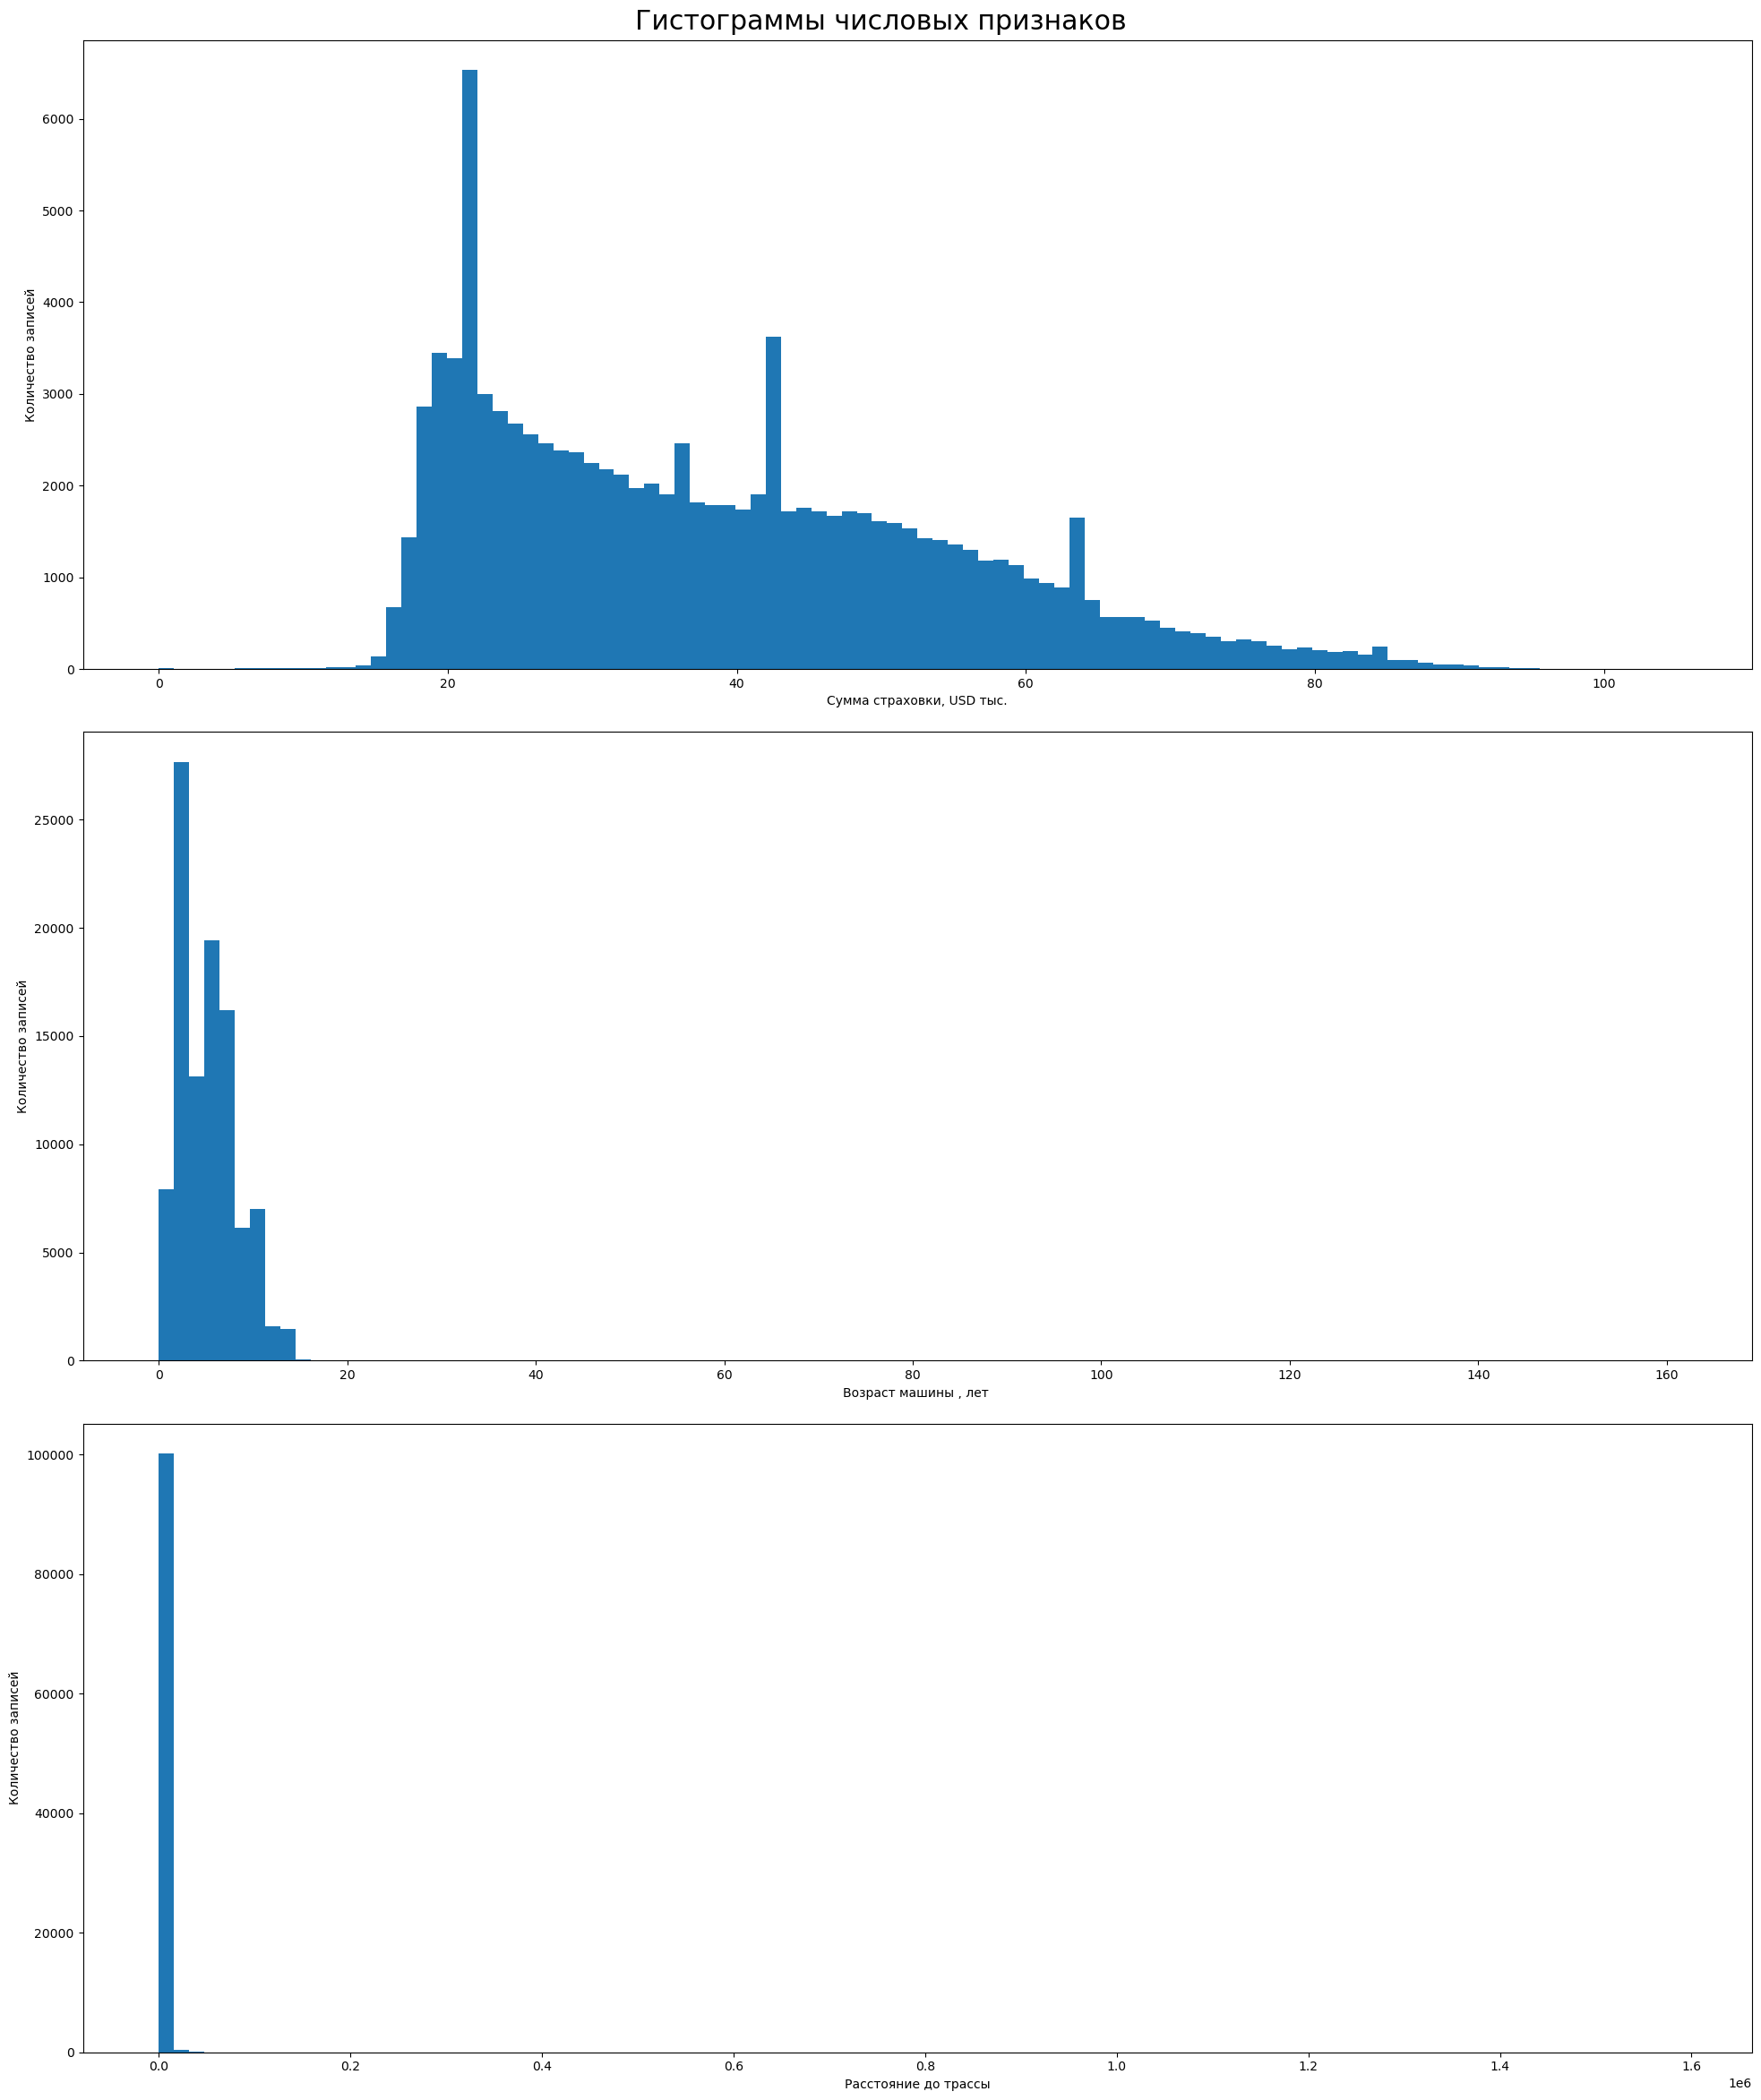

In [9]:
hist_figures,hist_axs = plt.subplots(3,1,figsize=(20,24))
hist_names =['Сумма стрaховки, USD тыс.', 'Возраст машины , лет ','Расстояние до трассы']
for i in range(len(num_cols)):    
    hist_axs[i].hist(df[num_cols[i]],bins = 100 )
#    plt.title('Гистограмма возраста машины');
    hist_axs[i].set_xlabel(hist_names[i]);
    hist_axs[i].set_ylabel('Количество записей');
plt.rcParams['font.size'] = 18
plt.suptitle('Гистограммы числовых признаков')
plt.tight_layout()    

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Здесь и далее
    
Необходимо оформить графики в соответствии с рекомендациями:
- название графика
- названия осей
- при необходимости легенда
- убирать техническую информацию по типу AxesSubplot:', с помощью команды plt.show()

Полезные ссылки по офрмлению графиков:
- <a href='https://www.python-graph-gallery.com/'>Галерия графиков на Python</a>
- <a href='https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/'>Улучшаем гистограммы</a>
- <a href='https://extremepresentation.typepad.com/.a/6a00d8341bfd2e53ef0111683a7591970c-pi'>Схема для выбора визуализации в зависимости от задач.</a>
- <a href='https://habr.com/ru/post/468295'>50 оттенков matplotlib</a>

</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Перерисовал графики. <br>
Я все же думаю , что не надо ставить на каждый субплот отдельное название, оно же будет дублировать xlabel? <br>
Я какую информативную метку можно поставить на ось Y в гистограмме, если понятно, что это гистограмма?
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> В данном варианте вопросов нет. Название оси всегда должно быть, дабы не вводить в заблуждение и не создавать лишних вопросов.

In [10]:
df[df.vehicle_age>20]

,city,county,distance,intersection,weather_1,location_type,surface,road_condition_1,lighting,control_device,...,weekday,hour,at_fault,insurance_premium,sobriety,drug,phone,vehicle_type,vehicle_transmission,vehicle_age
14741,1942,los angeles,0.0,1,clear,ramp,dry,normal,dusk or dawn,functioning,...,4,05,0,22.0,had not been drinking,MISSING,0,sedan,manual,161
71283,1942,los angeles,449.0,0,clear,MISSING,dry,normal,daylight,none,...,4,11,1,18.0,had not been drinking,MISSING,0,sedan,manual,161


Два выброса по возрасту машины , возможно даже один и тот  же автомобиль.

In [11]:
df.loc[df.vehicle_age>20 ,'vehicle_age'] = df.vehicle_age.median()

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»:</b> Так как модель разрабатывается для сервиса каршеринга, то я бы ограничился возрастом автомобилей в 10 лет

по первой  колонке все нормально, вторая исправлена,  третья выглядит странно, но похоже дело в том, что там очень много нулей, а оставшиеся значения сильно размазаны.
Небольшое преобразование показыает что распределение здесь  тоже естественно - логарифмы значений отличных от 0, распределены нормально.


Квантили 0.4 - 0.6 для distance
 0.4     50.0
0.5    100.0
0.6    200.0
Name: distance, dtype: float64
Квантили для порядка расстояния
 0.3    2.565026
0.4    3.912043
0.5    4.605180
0.6    5.298322
0.7    5.958427
0.8    6.481579
0.9    7.367709
Name: distance, dtype: float64


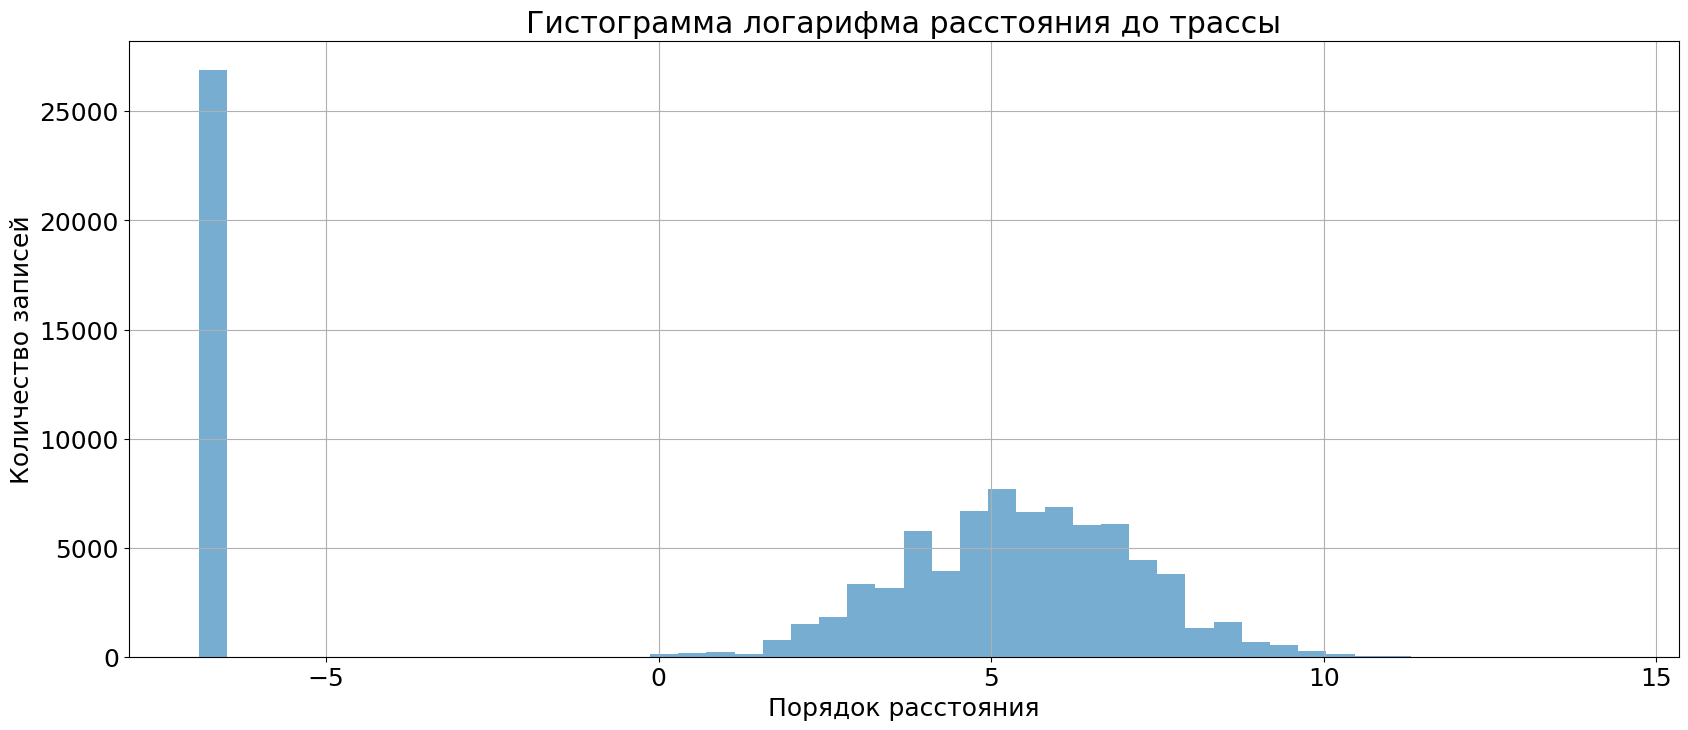

In [12]:
(df.distance+.001).apply(np.log).hist(bins=50,figsize=(20,8),alpha=.6);
plt.title('Гистограмма логарифма расстояния до трассы')
plt.xlabel('Порядок расстояния')
plt.ylabel('Количество записей')
print("Квантили 0.4 - 0.6 для distance\n", (df.distance.quantile([.4,.5,.6]) ) )
print("Квантили для порядка расстояния\n" ,(df.distance+.001).apply(np.log).quantile(list(np.arange(0.3,1,.1)) ) )

Однако расстояния  10тыс км от трассы невозможны, да и 1000 км много для Калифорнии, но такие цифры есть и распределены естественно
Их 10% и не хочется их выбрасывать (хотя на разведочной оценке пока наверно можно), и их нельзя оставлять, потому что это большие сдвиги вверх и они исказят картину

Text(0, 0.5, 'Количество записей')

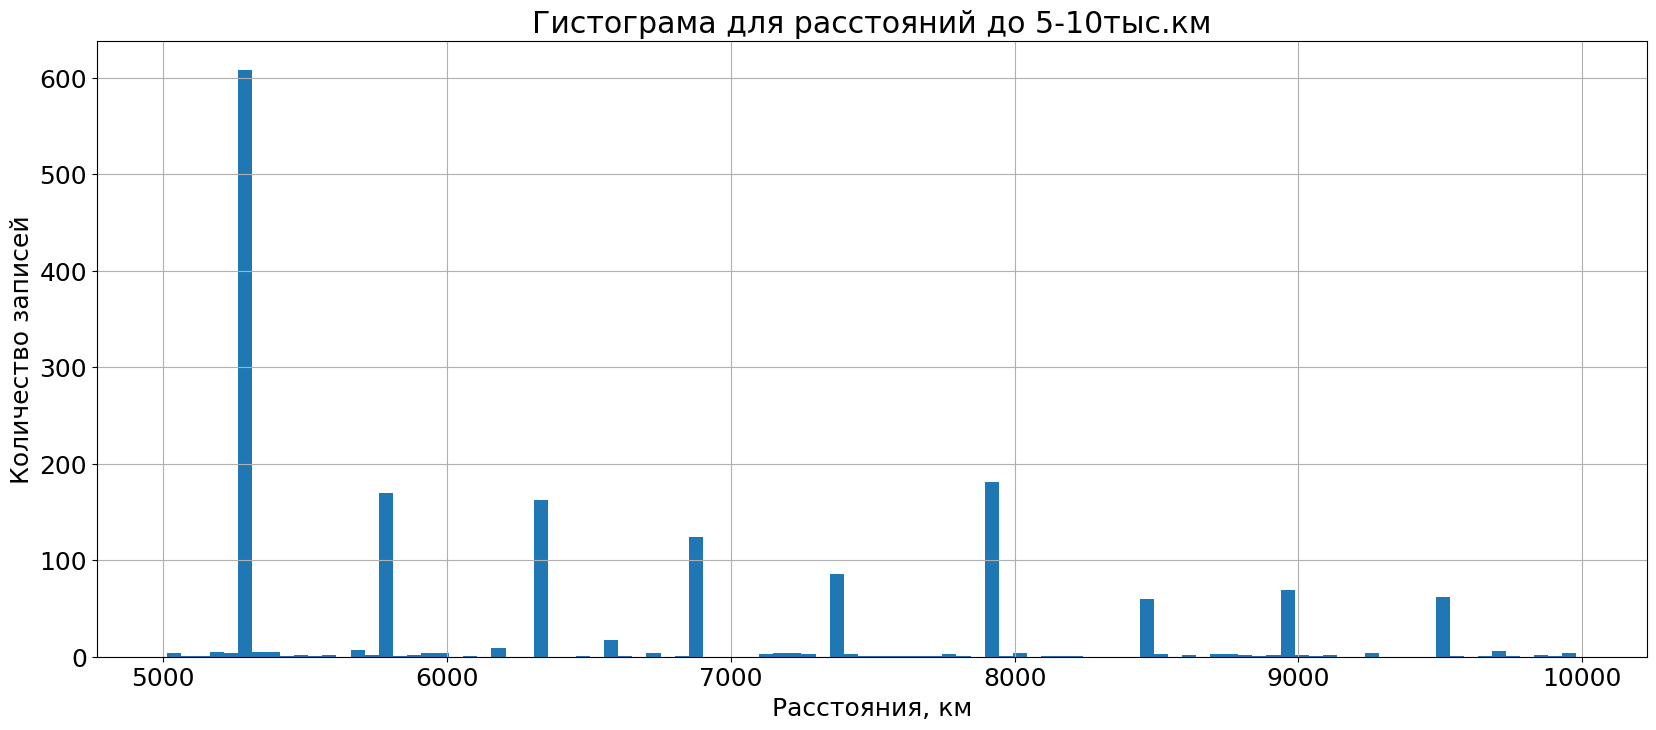

In [13]:
df.distance[(df.distance > 5_000) & (df.distance<10_000)].hist(figsize=(20,8),bins=100);
plt.title('Гистограма для расстояний до 5-10тыс.км')
plt.xlabel('Расстояния, км')
plt.ylabel('Количество записей')

Text(0, 0.5, 'Количество записей')

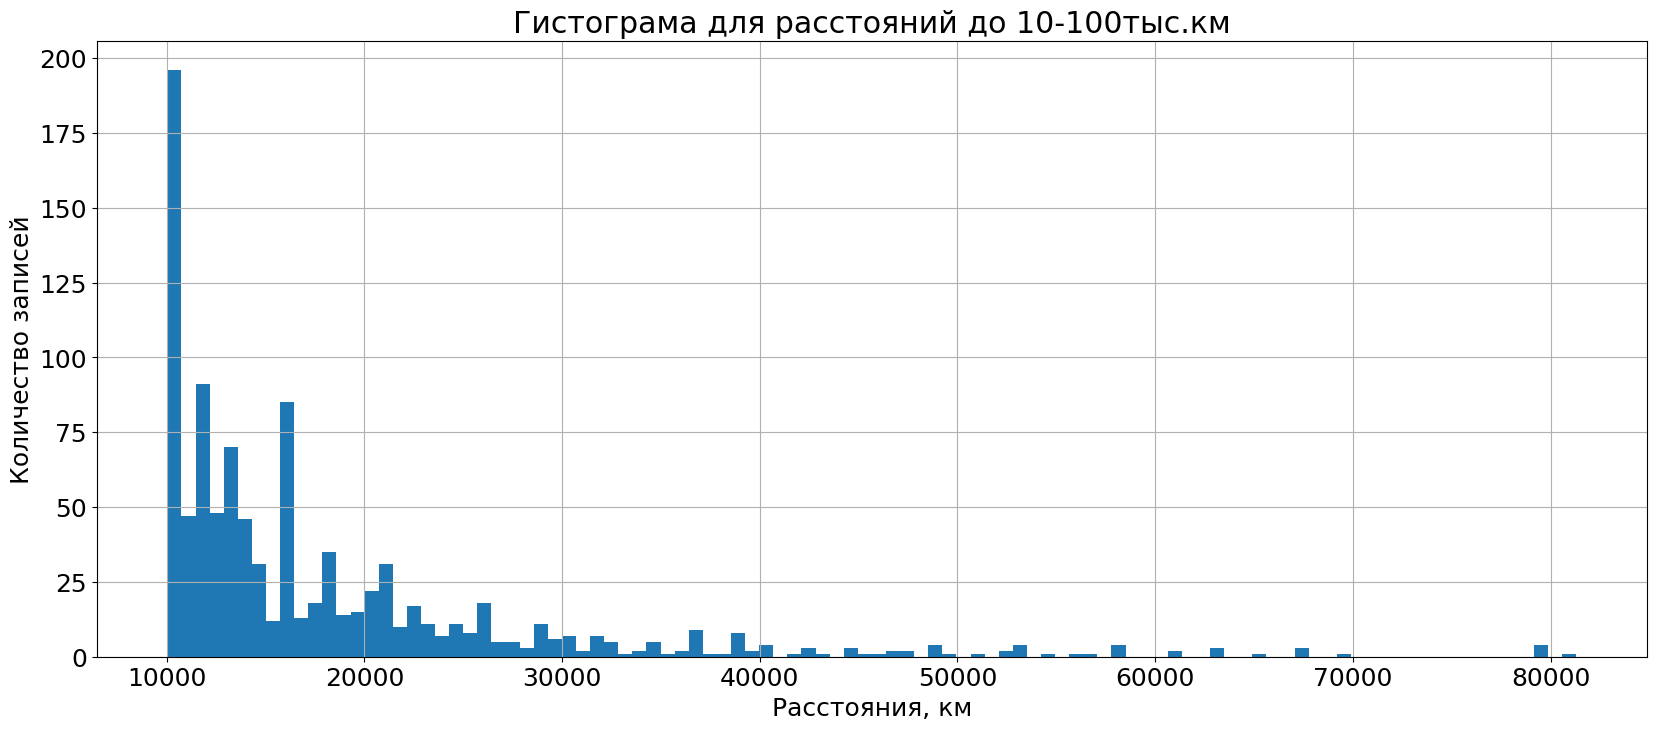

In [14]:
df.distance[(df.distance > 10_000) & (df.distance<100_000)].hist(figsize=(20,8),bins=100);
plt.title('Гистограма для расстояний до 10-100тыс.км')
plt.xlabel('Расстояния, км')
plt.ylabel('Количество записей')

Мы получим целые числа на пиках, если разделим distance на 1056

In [15]:
(df[df.distance> 1000].distance/1056).value_counts().head(20)


distance
1.000000     2372
1.500000     1738
2.500000     1609
2.000000     1052
5.000000      603
1.250000      590
1.420455      536
3.000000      505
3.500000      361
1.136364      323
1.893939      314
4.000000      307
4.500000      199
7.500000      181
5.500000      166
6.000000      162
10.000000     155
2.367424      147
6.500000      124
1.041667      124
Name: count, dtype: int64

А распределение по большим дистанциям будет очень напоминать базовое,если дистанцию поделить на 10.56

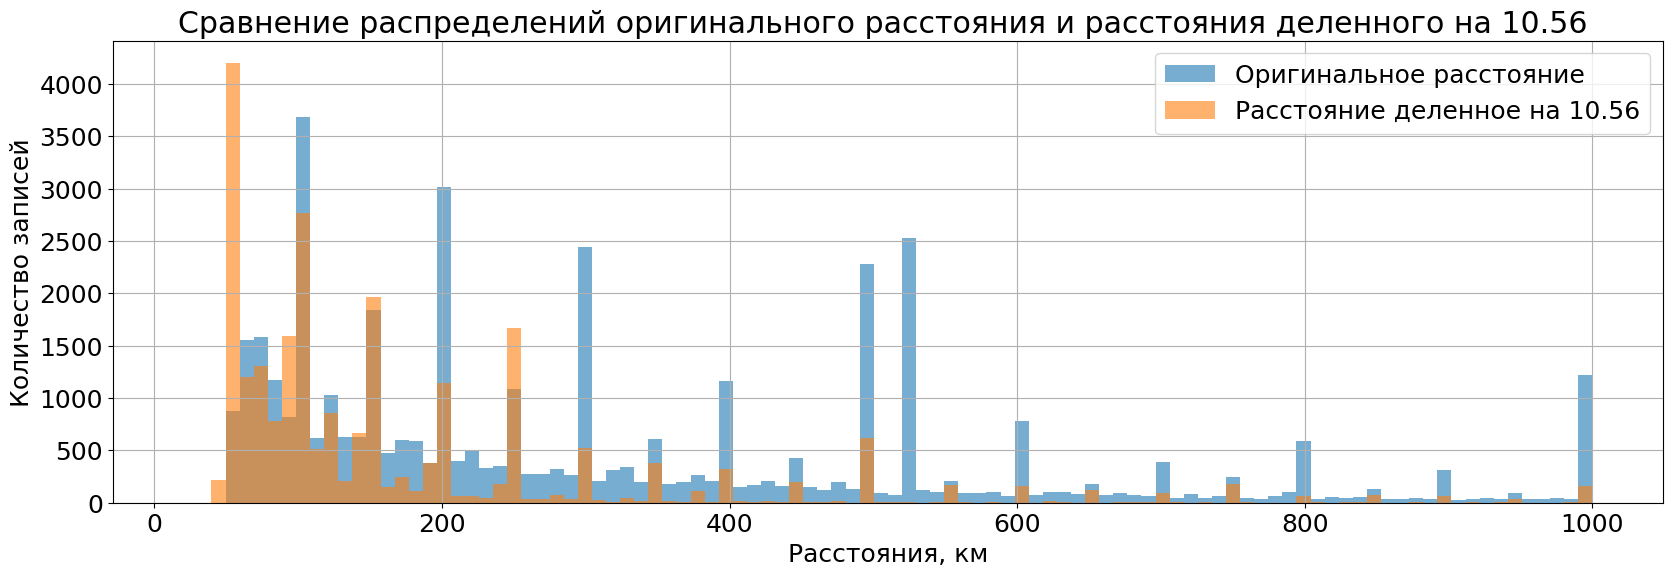

In [16]:
(df[df.distance>50].distance).hist(figsize=(20,6),bins=100,range=(20,1000),alpha=.6,label='Оригинальное расстояние');
(df[df.distance>500].distance/10.56).hist(bins=100,range=(20,1000),alpha=.6,label='Расстояние деленное на 10.56');
plt.title('Сравнение распределений оригинального расстояния и расстояния деленного на 10.56 ')
plt.xlabel('Расстояния, км')
plt.ylabel('Количество записей')
plt.legend();

В общем, я не знаю, что это такое, может какой-то кривой перевод в мили, но при таких совпадениях я думаю можно верить числам даже без понимания того, что они означают. Так что в это ситуации я считаю лучшим решением поделить на 10.56 дистанции > 500  

In [17]:
df['distance']=df.distance.apply(lambda d: [d,d/10.56][d>500] )

Осталось полпроцента записей с нереальной дистанцией, для которых трудно найти закономерность, поэтому я поставлю им медиану(но по ненулевым значениям, т.к. здесь явно не нули )

In [18]:
df['distance']=df.distance.where(df.distance<1500, other=df[df.distance>0].distance.median())

##  Проведите статистический анализ факторов ДТП

для общего понимания ситуации оценим распространённость целевого признака

In [19]:
df.at_fault.mean()

0.44660358229131464

### Вред пьянства

Естественно предположить, что степень  очень сильно влияет на назначение виновника, и в общем, так оно и есть -   
пьяный признается виновным в 95 % случившихся с ним происшествий, слегка выпивший - в 71% , неясные ситуации располагаются по степени уверенности в пьянстве.   
Вероятно нужна какая-то наглядная диаграмма, но я даже не уверен, что правильно показывать - хотя пьяный почти всегда виноват, доля инцидентов с ними невелика и в общем итоге возможно мало влияет.

In [20]:
df.groupby('sobriety').at_fault.agg(['count','mean']).sort_values(by='mean',ascending=False)

,count,mean
sobriety,,
"had been drinking, under influence",5413,0.956586
"had been drinking, impairment unknown",319,0.811912
impairment unknown,1621,0.732264
"had been drinking, not under influence",801,0.714107
MISSING,1539,0.644574
had not been drinking,90321,0.404524
not applicable,592,0.347973


<b>Примечание</b>   
В задании требуется показать <i> зависимость числа ДТП от уровня трезвости </i>  
Честно говоря не понял, что имеется в виду, так как безаварийной статистики у нас нет и сравнивать статистику аварий не с чем .  
Требуется показать для каждой категории аварий/ повреждений долю пьяных в ней ?

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> На мой вгляд в таблице уже представлен ответ на впорпос задания.

#### Зависимость ДТП от суммы страховки

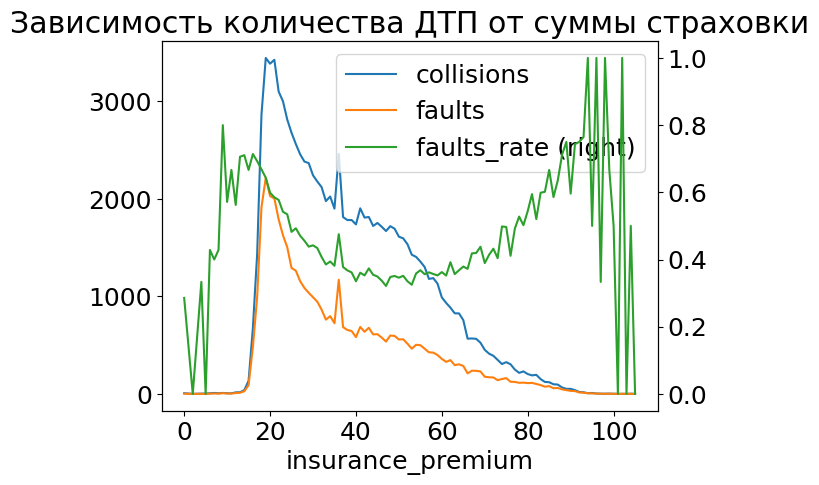

In [21]:
df_ip = df.groupby('insurance_premium').at_fault.agg(['count','sum', 'mean'])
df_ip.columns = ['collisions','faults','faults_rate']
df_ip.plot(secondary_y=['faults_rate'],title='Зависимость количества ДТП от суммы страховки');

Зависмость сложная. Видимо средний класс использует страховки на суммы $20-40K  
В этих пределах доля виновности  падает со стоимостью страховки.  
Но вне этих пределов она наоборот растёт!

#### Зависимость ДТП от возраста автомобиля

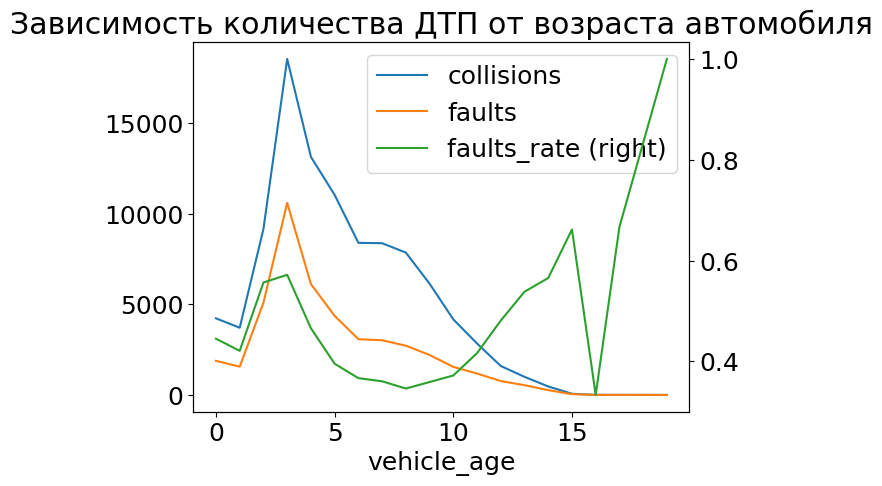

In [22]:
df_va = df.groupby('vehicle_age').at_fault.agg(['count','sum', 'mean'])
df_va.columns = ['collisions','faults','faults_rate']
df_va.plot(secondary_y=['faults_rate'],title='Зависимость количества ДТП от возраста автомобиля');


In [23]:
df_va

,collisions,faults,faults_rate
vehicle_age,,,
0,4222,1878,0.444813
1,3705,1559,0.420783
2,9146,5089,0.556418
3,18521,10588,0.571675
4,13123,6110,0.465595
5,11026,4358,0.395248
6,8385,3074,0.366607
7,8363,3014,0.360397
8,7847,2715,0.345992


Доля виновности минимальна для автомобилей возраста 5-10 лет и поднимается для крайних значений.  
Можно строить предположения о причинах, но  основной гипотезы нет.

### Распределение ДТП по месяцам

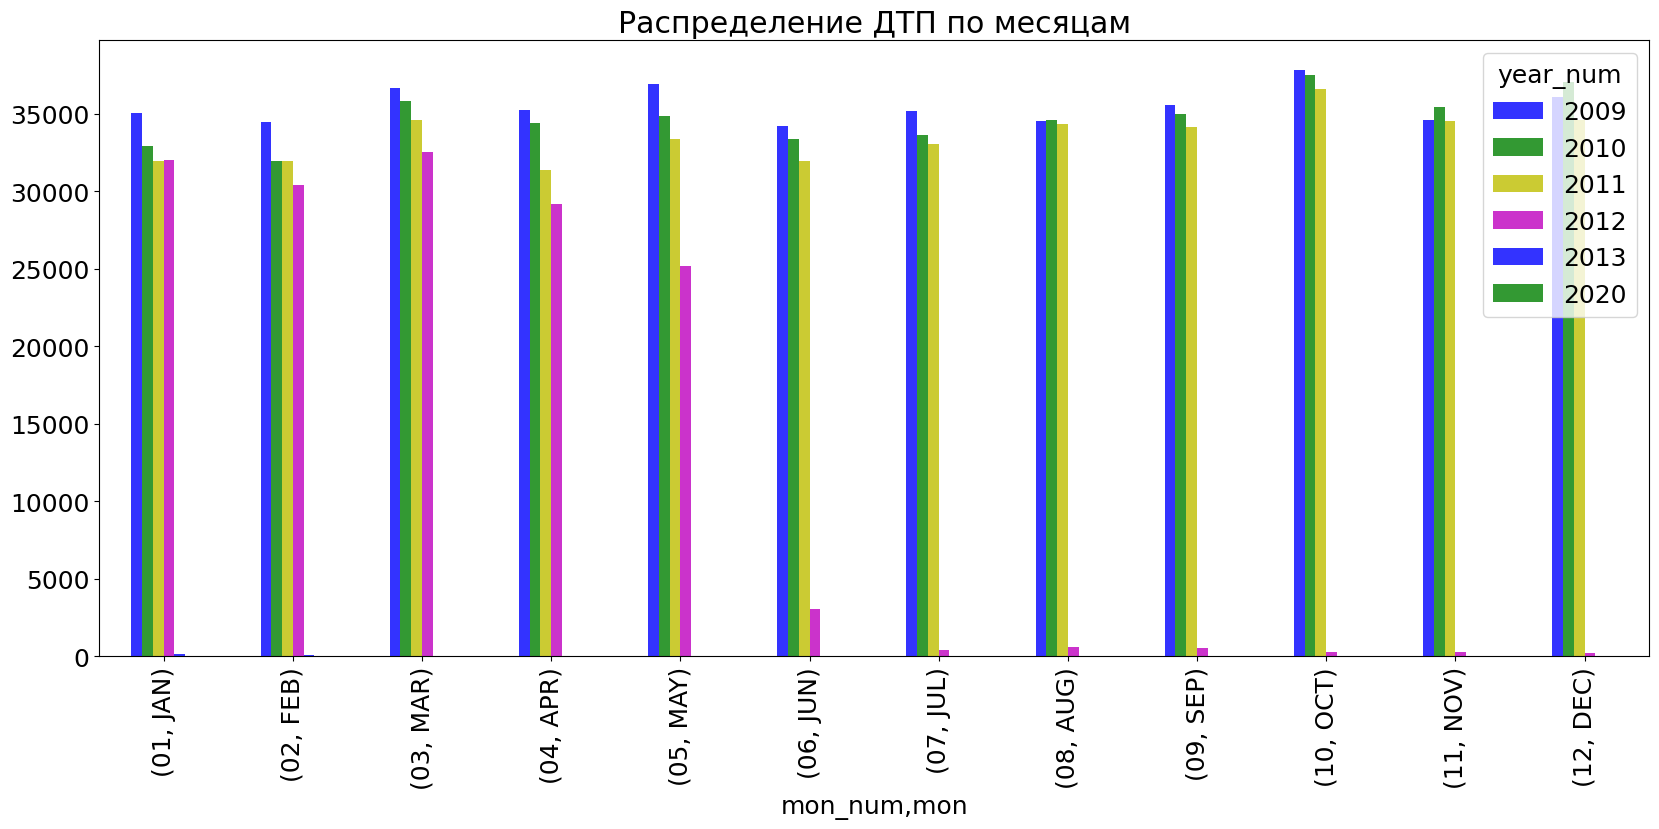

In [24]:
query = f"""
select to_char(collision_date,'YYYY') year_num,
       to_char(collision_date,'MM') mon_num,
       to_char(collision_date,'MON') mon,
       count(*) qty
  from collisions c
  where  c.collision_damage <> 'SCRATCH'
  group by 1,2,3 
  order by 2,1
"""
dm = pd.read_sql_query(query,con=engine)
dm =dm.pivot_table( index=['mon_num','mon'], columns='year_num', values= 'qty')
dm.plot.bar(title='Распределение ДТП по месяцам',
            color=['b','g','y','m'],
            alpha=.8,
            figsize=(20,8)
           );


Существуют небольшие пики в марте и конце года, но самое главное - за 2012 год данные только до июня!  

Это обесценивает требование использовать 2012 для анализа - надо или расширять данные за этот год или откатываться на предыдущий - осенью вполне может быть анаомалия, которую мы не увидим.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Молодец, что заметил момент про неполные данные

###  Распределение ДТП по причинам

Иллюстративный запрос, который не может быть прямо  использован в модели (так как оба фактора неизвестны на момент предсказания), но косвенно может помочь в определении критических точек. 

In [25]:
query = '''
select pcf_violation_category,count(*) qty
 from collisions c 
 join parties p using(case_id)
 where  extract('YEAR' from c.collision_date) = 2012
  and c.collision_damage <> 'SCRATCH'
  and p.at_fault=1
 group by 1
 order by 2 desc
'''
dr = pd.read_sql_query(query,con=engine)
cutoff = .05
dr =  dr.set_index(dr.pcf_violation_category).qty 
dr  = pd.concat([dr[dr/dr.sum()>= cutoff] ,
           pd.Series( dr[dr/dr.sum()<cutoff].sum(),index=['OTHER'] )])

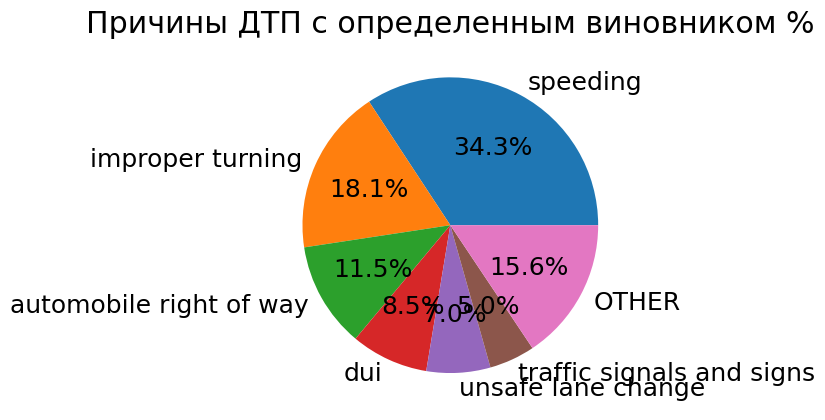

In [26]:
dr.plot.pie(autopct='%1.1f%%',title='Причины ДТП c определенным виновником %');

Половина инцидентов происходит по двум причинам - превышение скорости и неправильный поворот. Можно рассмотреть отслеживание скорости онлайн и какой-нибудь доступ к камерам на перекрёстках.

Третья по частоте причина как я понимаю - нарушение порядка проезда, так что можно ещё принимать экспресс-экзамен по ПДД :) 

### Список задач для рабочей группы

Необходимо отобрать для анализа наиболее важные для нас признаки, влиящие на ДТП  

Признаки можно разделить на объективные (одинаково относящиеся ко всем участникам ) и субъективные (различающиеся для участников). Объективные  признаки  хранятся в таблице collisions, субъективные - в таблицах parties  и vehicles.

Проблема анализа объективных признаков в том, что они мало помогают в реализации основной идеи заказчика - предсказанию вины конкретного участника.  
Объективные признаки могли бы помочь в предсказании вероятности аварии , но у нас нет данных о частоте аварий и о продолжительности беаварийной езды. Косвенно, влияние объективных признаков можно оценить по серьезности инцидентов в группе и по количеству инцидентов с одним участником.  

Субъективные признаков хорошо помогают в реализации основной идеи, но их слишком мало, чтобы строить серьехную модель, так что в дкльнейшем видимо придётся как-то привлекать объективные признаки. 

Также следует оценить возможные дополнительные целевые признаки, которые могут представлять интерес для заказчика, в частности ущерб collision_damage  и возможно primary_collision_factor и violation_category (от них может зависеть размер страховых выплат) . Эти признаки неизвестны в момент предсказания и в любом случае не могут  быть учтены в модели, но могут быть предсказаны. 

Окончательная постановка задачи зависит от того, что хояет получить заказчик, здесь есть некоторая неясность -   
с одной стороны, надо предсказывать вероятность аварии в конкретной ситуации, для чего не хватет данных 
с другой - предсказывать виновника, для чего годится только несколько признаков из таблицы parties.

Я также  предполагаю, что интересует не только виновник, но и потенциальный ущерб от него , но пока задача так не ставится и нет целевой функции (ущерб можно предположить по размерам страховки, но непонятно какой реальный ущерб несёт в каждом случае компания). 

Предварительно, я бы выделил такие задачи (список будет уточнён по резултатам моделирования)
* Установить связь между физическим состоянием участника ДТП (трезвость, степень опъянения и усталость)  и виновностью , а также тяжестью аварии
* Проверить наличие связи между суммой страховки и виновностью, а также тяжести повреждений
* Доля в общей стоимости инцидентов (понимаемой как сумма страховки) различных субъективных причин(по крайней мере пьянства и <s>возраста автомобиля</s>)
    - Создать подзапрос collision_costs к базе данных, вычисляющий для каждого инцидента сумму страховок участников: 
        - для этого сгруппировать данные по case_id и вычислить сумму страховок участников для каждого инцидента
    - С помощью этого подзавроса посчитать суммарную стоимость страховок для каждой категории виновников по sobriety, 
        - для этого связать вторую копию parties c collision_costs по саse_id, 
        - сгруппировать по sobriety и отфильтровать по признаку виновности at_fault=1, 
        - суммировать стомиость страховок и количество инцидентов по группам, 
        - также вычислить средние стоимость инцидентов с помощью функции avg
    - Загрузить запрос в датафрейм, пересчитать количество и суммарную стоимость страховок в проценты
    - Иллюстрировать результаты круговыми диаграммами, сравнить их между собой
    - Построить столбчатую диаграмму для средней стоимости инцидента в зависимости от трезвости



* Проверить наличие связи между локацией (город + графство) и виновностью водителя в ДТП с одним участником.

    - Построить запрос:
        - связать таблицы collisions и partis по case_id
        - применить ограничения по году, количеству участников(party_count=1), типу аварии
        - применить группировку по городу и для каждого города:
        - найти количество записей в базе(count)
        - найти количество виновников,просумировав fault_at
        - найти количество пьяных просуммировав 1 для инцидентов с пьяными водителями
    - загрузить запрос в датафрейм
    - в датафрейме посчитать доли виновных и пьяных водителей по городам
    - найти коэффициент корреляции между этими векторами
    - для 10 крупнейших по количеству инцидентов городов вывести доли виновных и пьяных на столбчатую диаграмму
    - повторить процедуру для другого  уровня повреждений


* Прверить связь между локацией и причинённым ущербом
* Есть ли локации,  доля которых в авариях выросла за время наблюдений?

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> 2 из 6 задач необходимо решить "2.2. Пропишите порядок решения для двух задач из списка". Обрати внимание: "Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц."

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v2:</b>

<b>⛔️«Надо исправить»:</b> Не увидел решения второй задачи.

<div class="alert alert-block alert-info" >
   <font color="green">.
        <b>Комментарий студента v2:</b> <br>
        Добавил решения в к задачам 1 и 4  <br>
        Не знаю насколько понятно, проще запрос написать :)
   </font>
</div>

## Создайте модель для оценки водительского риска

Выбор признаков для модели описан в комментарии к основному запросу данных для модели, часть 2

Я стремился работать с моделями по возможности одинаково, убирая код в стандартыне классы, так чтобы различались тольок тип модели и решетка параметров. Для градиентного бустинга выбраны модели LGBM  и Catboost, для нейросети - MLP. Насколько я понял из документации, при поиске оптимума все градиентные алгоритмы бинарной классификации используют оценку log_loss/cross_entropy. 
Для каждой модели  запускается кроссвалидация на тренировочном наборе и лучший набор параметров проверяется на тестовом наборе.   
Затем формируются  графики зависимости от параметров.
Для оценки влияния признаков используется билиотека SHAP

### Вспомогательные классы для обучения модели и анализа результата

Вспомогательные классы для сбора результатов кроссвалидации и их отрисовки

#### Parsed Result

Этот класс собрает из результатов кроссвалидации фрейм с мультииндексомм по колонкам,
соответвующим нетривиальным слоям тестируемой решетки. 

In [27]:
class ParsedResult:
    def __init__(self,result,force_string_cols=[],metric_name='score'):
        self.df = pd.DataFrame.from_dict( 
            { k:v for k,v in result.items() if k not in ['params']}
        )
# drop param_ prefix from column names for tidy display         
        self.primary_score='mean_test_'+metric_name
        param_names = [ c for c in self.df.columns if c[:6]=='param_' ]        
        self.param_cols = [ c[6:] for c in param_names ]              
        self.df = self.df.rename( columns={ p:c for p,c in zip(param_names,self.param_cols) } )
# also drop model_ prefix which we use for model grid in pipeline   
        model_names = [ c for c in self.df.columns if c[:7]=='model__' ]
        self.param_cols = [c[7:]  if c[:7]=='model__' else c for c in self.param_cols ]
        self.model_cols = [ c[7:] for c in model_names ]   
        self.df = self.df.rename( columns={ p:c for p,c in zip(model_names,self.model_cols) } )
# select parameters, for which tested several values and arrange them descending (by number of differnt values)
        values_per_cols = list(zip( self.param_cols,[ len( np.unique( self.df[c].values ) ) for c in self.param_cols]))
        self.multi_value_cols =[it[0] for it in sorted(values_per_cols, key=lambda pair:pair[1],reverse=True) if it[1]>1 ]
# some object columns may be not string (f.e. lists)
        for c in force_string_cols:
            self.df[c]=self.df[c].apply(str)
    
    def select(self, index,values=[],filters={},agg=[] ):
        values = [ [self.primary_score] ,values][bool(values)]
        if len(filters)>0 :
            condition = 'and'.join([ f" {k}=={v} " for k,v in filters.items() ]) 
            filtered = self.df.query(condition)    
        else:
            filtered = self.df
        cols = [ c for c in self.multi_value_cols if c not in list(filters.keys())+[index]+values ]      
        return(self.df.pivot_table(index=index,values=values,columns=cols)  )

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Молодец, что используешь классы, это позволяет сильно оптмизироват код. 

#### ResultPlotter

Два класса для отрисовки графиков :    
Вспомогательный класс формирования аттрибутов линий для графиков, создаваемых в основном плоттере

In [28]:
class Styler:
    base_array=[]
    def __init__(self,param_array=[]):
        self.params = [ self.base_array,param_array][bool(param_array)]
    
    def key(self):
        pass
    
    def put(self,dct,index):
        dct[self.key()] = self.params[index]
        
class ColorStyler(Styler):
    base_array=[*'rgbykm']
    def key(self):
        return('color')

class DashStyler(Styler):
    base_array=['--',':','-.','-']
    def key(self):
        return('ls')
    
class WidthStyler(Styler):
    base_array=[ 2,4,7]
    def key(self):
        return('lw')

class AlphasStyler(Styler):
    base_array=[ .3,.9]
    def key(self):
        return('alpha')
    

И собственно плоттер, рисующий каждый столбец мультиколонки в своем стиле.   
Отельные непересекающиеся аттрибуты создаются для каждого уровня мультиколонки,   
в результате каждая элементарная подколонка получает уникальный стиль   

In [29]:
class ResultPlotter:
    base_params = {
        'colors':[*'rgbykm'],
        'styles':['--',':','-.','-'],
        'widths':[ 2,4,7],
        'alphas':[.3,.8],
        'figsize': (20,8),
        'logscale':""
    }
    
    def __init__(self, test, params = {} ):
        self.model = test.model
        self.df= test.sel
        self.params=self.base_params | params
        self.stylers = [ColorStyler(self.params['colors']),DashStyler(self.params['styles']),
                        WidthStyler(self.params['widths']),AlphasStyler(self.params['alphas'])]
        self.mcols = self.df.columns
        self.lev_names = self.mcols.names[1:]
        self.num_levels= len(self.lev_names)
        self.level_sizes=[ len(set(self.mcols.get_level_values(x))) for x in self.lev_names]

# auxliary func to forms sequence of indexes for levels
# result is need index on the level  which may be one of color|dashstyle|linewidth
    def idx_on_level(self,idx, lev_num):
        items_on_hyperplane = multiply(self.level_sizes[(lev_num+1):]) 
        return idx//items_on_hyperplane% self.level_sizes[lev_num]
    
    def plot(self):
        fig,ax = plt.subplots(figsize=(20,6))
        if 'x' in self.params['logscale'].lower():
            ax.set_xscale('log')
        
        for i in range(len( self.mcols)):
            graph_params = {}
            for i_level in range(self.num_levels):
                self.stylers[i_level].put( graph_params, self.idx_on_level(i,i_level) ) 
            idx=self.mcols[i]
            
            graph_params['label'] = ','.join( [ f"{n}:{i} " for n,i in zip(self.lev_names,idx[1:]) ] )
            ax.plot(self.df[idx] ,**graph_params)
            ax.set_title(f'Тест {type(self.model).__name__}')
            ax.set_xlabel('learning rate')
            ax.set_ylabel('log_loss metric')
            ax.legend()

#### Класс для универсального теста на модели

Содержит программу стандартного теста

In [30]:
def plot_pr(y,proba):
    precision, recall, thresholds = precision_recall_curve(y, proba[:, 1])
    plt.figure(figsize=(10, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show() 

In [31]:
class TestModel:
    def __init__(self, model,fit_params={},scoring=['f1','roc_auc'] ):
        self.model = model
        self.fit_params=fit_params
        self.scoring = scoring
        
    def cross_validate(self,param_grid,X_tr,y_tr,refit=None):
        self.refit = [self.scoring[0],refit ][bool(refit)]
        self.cv = GridSearchCV(self.model, param_grid,cv=4, scoring=self.scoring,refit=self.refit,return_train_score=True) 
        self.cv.fit(X_tr,y_tr,**self.fit_params)
        self.best = self.cv.best_params_
        return self.best
    
    def check_best(self,X_tr,y_tr,X_te,y_te):
        model = self.model.set_params(**self.best)
        model.fit(X_tr,y_tr,**self.fit_params)
        pr = model.predict(X_te)
        for metric in [f1_score,precision_score,recall_score,accuracy_score]:
            print(f"{metric.__name__}: {metric(y_te,pr)} \t")
        print( "confusion_matrix:\n",confusion_matrix(y_te,pr) )
        proba = model.predict_proba(X_te)
        plot_pr(y_te,proba)
    
    def parse_result(self,index_column='learning_rate',forced_string_cols=[]):
        self.res = ParsedResult(self.cv.cv_results_,forced_string_cols,metric_name=self.refit)
        self.sel = self.res.select(index_column)
        return self.sel
        
    def plot(self):
        self.rp = ResultPlotter(self,{'logscale':'x'})
        self.rp.plot()
         

### Описание структуры данных и  разбиение на тренажер и тест

In [32]:
y = 'at_fault'
X = [ c for  c in df.columns if c!=y ]
cat_cols = [ c for c in df.columns if df.dtypes[c] in [ 'object','category']  ] 
num_cols = [ c for c in df.columns if df.dtypes[c] in ['int','int64','float','float64' ] ]

In [33]:
df.dtypes

city                     object
county                   object
distance                float64
intersection             object
weather_1                object
location_type            object
surface                  object
road_condition_1         object
lighting                 object
control_device           object
month                    object
weekday                  object
hour                     object
at_fault                  int64
insurance_premium       float64
sobriety                 object
drug                     object
phone                    object
vehicle_type             object
vehicle_transmission     object
vehicle_age               int64
dtype: object

In [34]:
for c in cat_cols:
    df[c] = df[c].astype('category')


In [35]:
X_tr,X_te,y_tr,y_te = train_test_split(df[X],df[y], test_size = .25, stratify = df[y], shuffle= True ) 

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Необходимо обосновать выбор метрики.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Должен сказать у меня нет окончательного ответа.  <br> 
Понятно только, что метрика в этой работе должна быть одна для всех.   <br>
Ниже соображения, почему выбрал F1
</div>

Основной метрикой для бинарной классификации модно выбрать одну из accuracy, F1 или AUC-ROC  
В этой задаче между тестовый набор сбалансирован и вроде бы можно прямо выбрать  accuracy,  
но мы проводим только предварительное исследование и не даём окончательного предсказания  
поэтому я из этих двух выбираю  F1, как более устойчивую, чтобы сравнивать с ней будущие модели, 
которые неизвестно как будут эволюционировать

Из этих соображений,  AUC-ROC еще лучше, но меня насторожило что в тесте нейросети при неплохой AUC-ROC мог быть завал модели в ту или другую сторону, с чисто позитивными и чисто негативными ответами. 
Я сейчас не могу сказать , какой форме ROC кривой это соответствует, видимо там надо ставить экстремальные пороги.  
Но мне не хотелось бы получить такой странный результат, поэтому я всё же выбрал F1 которая гаранитрует отсутствие таких проблем

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Молодец, что обосновал выбор метрики.
Отметим один важный момент: Нам важно не показывать сообщения и не проводить проверки при *`false-positive`* ошибках  - излишние процедуры будут нервировать водителей и они будут уходить к конкурентам, т.е. нам важно определять *`precision`*.    
Однако так как речь идет о безопасности жизни водителя и пешеходов, то нам также важно определять *`recall`*.
    
Поэтому логичным выборам является *`f1-мера`* - метрика объединяющая *`precision`* и *`recall`*

#### LGBM

In [36]:
%%time
params_grid = {
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['binary'],
    'is_unbalance':[True,False],
    'learning_rate': [.3,.1,.03,.01,.003],
    'n_estimators': [128,256,512],
#    'n_estimators':[16],
    'boosting' :['gbdt','dart'],
    'max_depth':  [256],
    'num_leaves': [512]       
}
lgbm = TestModel(lgb.LGBMClassifier( verbose = -1))
lgbm.cross_validate(params_grid,X_tr,y_tr)

CPU times: user 4h 7min 36s, sys: 23.5 s, total: 4h 7min 59s
Wall time: 1h 2min


{'boosting': 'dart',
 'is_unbalance': True,
 'learning_rate': 0.03,
 'max_depth': 256,
 'n_estimators': 256,
 'num_leaves': 512,
 'objective': 'binary',
 'subsample': 0.25,
 'subsample_freq': 4}

f1_score: 0.5855695837933849 	
precision_score: 0.6354448843509064 	
recall_score: 0.5429537968485711 	
accuracy_score: 0.6567668575063613 	
confusion_matrix:
 [[10420  3499]
 [ 5134  6099]]


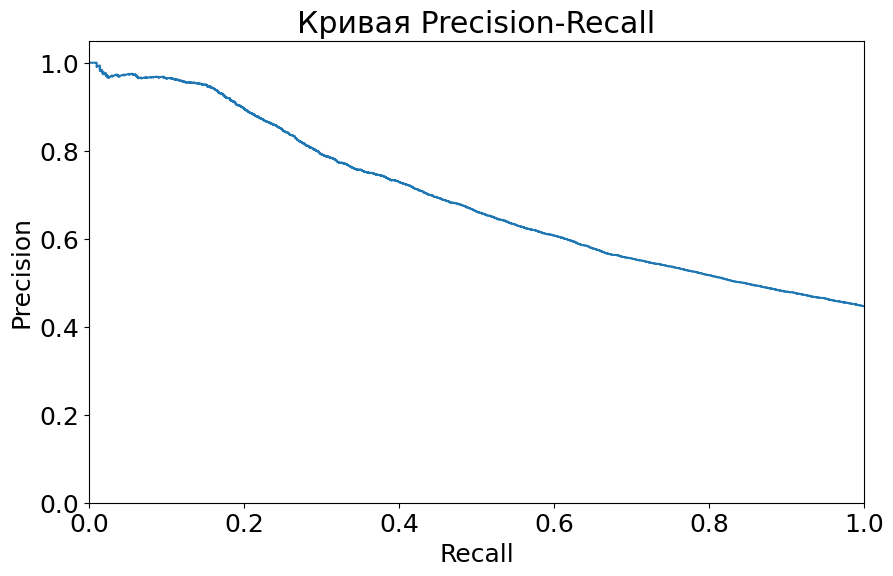

In [37]:
from sklearn.metrics import precision_recall_curve
lgbm.check_best(X_tr,y_tr,X_te,y_te)

 Матрица ошибок перекошена в сторону FN 
 Лучшая целевая метрика .578 при этом точность .65

In [38]:
lgbm.parse_result()

mean_test_f1                                                    \
n_estimators           128                                     256             
boosting              dart                gbdt                dart             
is_unbalance         False     True      False     True      False     True    
learning_rate                                                                  
0.003             0.389901  0.440636  0.437655  0.487717  0.514226  0.552617   
0.010             0.523269  0.562374  0.535578  0.571625  0.547405  0.581162   
0.030             0.549636  0.580490  0.553588  0.581887  0.555498  0.584294   
0.100             0.552331  0.575202  0.546152  0.559166  0.549834  0.568620   
0.300             0.535988  0.550319  0.528610  0.533742  0.536108  0.544740   

                                                                           
n_estimators                            512                                
boosting           gbdt                dart                gbdt            
is_unbalance      False     True      False     True      False     True   
learning_rate                                                              
0.003          0.515009  0.551301  0.541011  0.575367  0.543510  0.574367  
0.010          0.551337  0.582560  0.552726  0.583848  0.557009  0.582772  
0.030          0.553216  0.574986  0.554786  0.579238  0.548622  0.564946  
0.100          0.539092  0.548289  0.545536  0.557202  0.533732  0.540383  
0.300          0.524953  0.529082  0.531809  0.533151  0.522632  0.524555

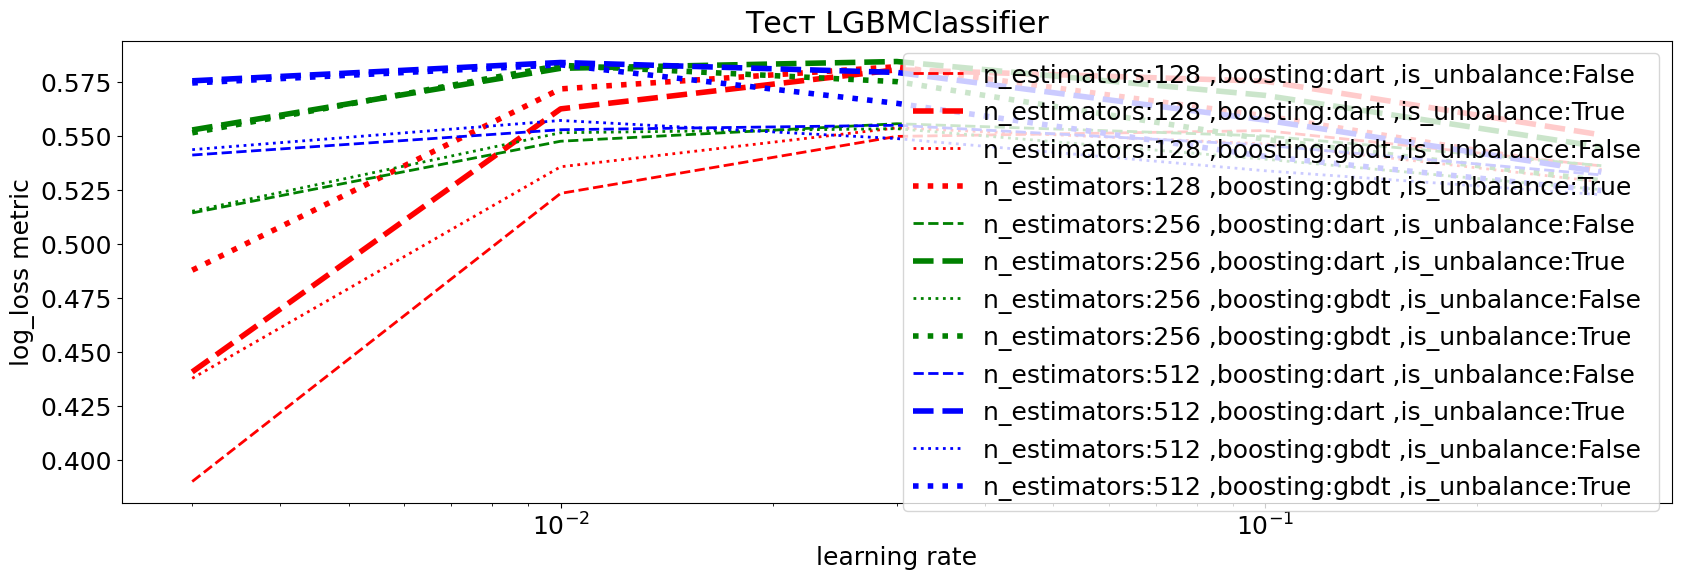

In [39]:
lgbm.plot()

Лучший результат при скоростях обучения 0.03-0.1  
При таких скоростях  результат довольно стабилен 

#### Catboost

Хотя модель позволяет задавть не только функцию потерь но и финальную метрику, похоже при тренировке/кроссвалидации этот параметр не учитывется и в качестве test_score выводится функция потерь. 

In [40]:
cbst = TestModel(cbs.CatBoostClassifier(logging_level='Silent' ),fit_params={'cat_features':cat_cols})
params_grid = {
    'loss_function' :['Logloss'],
    'eval_metric':['F1'],
    'scale_pos_weight':[.5,1,2],
    'iterations': [64,128,256,512],
#    'iterations': [64],
    'learning_rate': [.6,.3,.1,.03,.01,.003]
}
cbst.cross_validate(params_grid,X_tr,y_tr)

{'eval_metric': 'F1',
 'iterations': 512,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'scale_pos_weight': 2}

f1_score: 0.6729878884403127 	
precision_score: 0.5762400101484206 	
recall_score: 0.8087777085373453 	
accuracy_score: 0.6489742366412213 	
confusion_matrix:
 [[7238 6681]
 [2148 9085]]


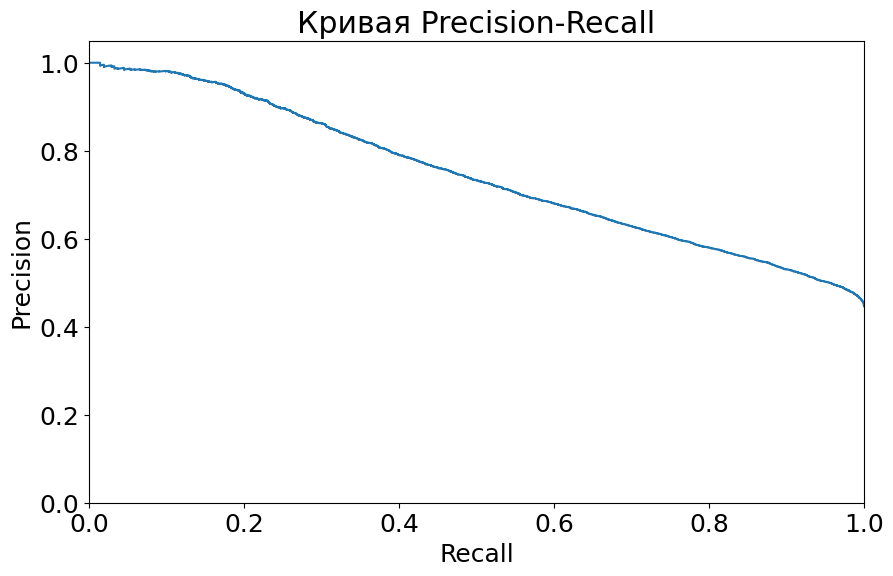

In [41]:
cbst.check_best(X_tr,y_tr,X_te,y_te)

F1 гораздо лучше - .67
Модель также перекошена но в другую сторону (FP). Точность примерно такая же как  у LGBM 

In [42]:
cbst.parse_result()

mean_test_f1                                          \
iterations                64                            128             
scale_pos_weight          0.5       1.0       2.0       0.5       1.0   
learning_rate                                                           
0.003                0.304953  0.512326  0.625726  0.305332  0.513786   
0.010                0.306601  0.512945  0.626311  0.315867  0.512434   
0.030                0.320801  0.518652  0.633775  0.340819  0.534561   
0.100                0.362755  0.541781  0.637044  0.380000  0.548305   
0.300                0.391987  0.550610  0.637233  0.399443  0.552464   
0.600                0.403547  0.549931  0.632535  0.414440  0.549735   

                                                                              \
iterations                       256                           512             
scale_pos_weight       2.0       0.5       1.0       2.0       0.5       1.0   
learning_rate                                                                  
0.003             0.625417  0.312617  0.511484  0.626530  0.320428  0.517647   
0.010             0.629968  0.331549  0.528058  0.636504  0.358182  0.544698   
0.030             0.636971  0.372773  0.553911  0.643059  0.399695  0.569781   
0.100             0.637434  0.415238  0.577422  0.662497  0.428950  0.584837   
0.300             0.635693  0.435390  0.587265  0.660863  0.451264  0.592452   
0.600             0.629628  0.458241  0.585027  0.653917  0.483839  0.588606   

                            
iterations                  
scale_pos_weight       2.0  
learning_rate               
0.003             0.634178  
0.010             0.640647  
0.030             0.657037  
0.100             0.664750  
0.300             0.659382  
0.600             0.648447

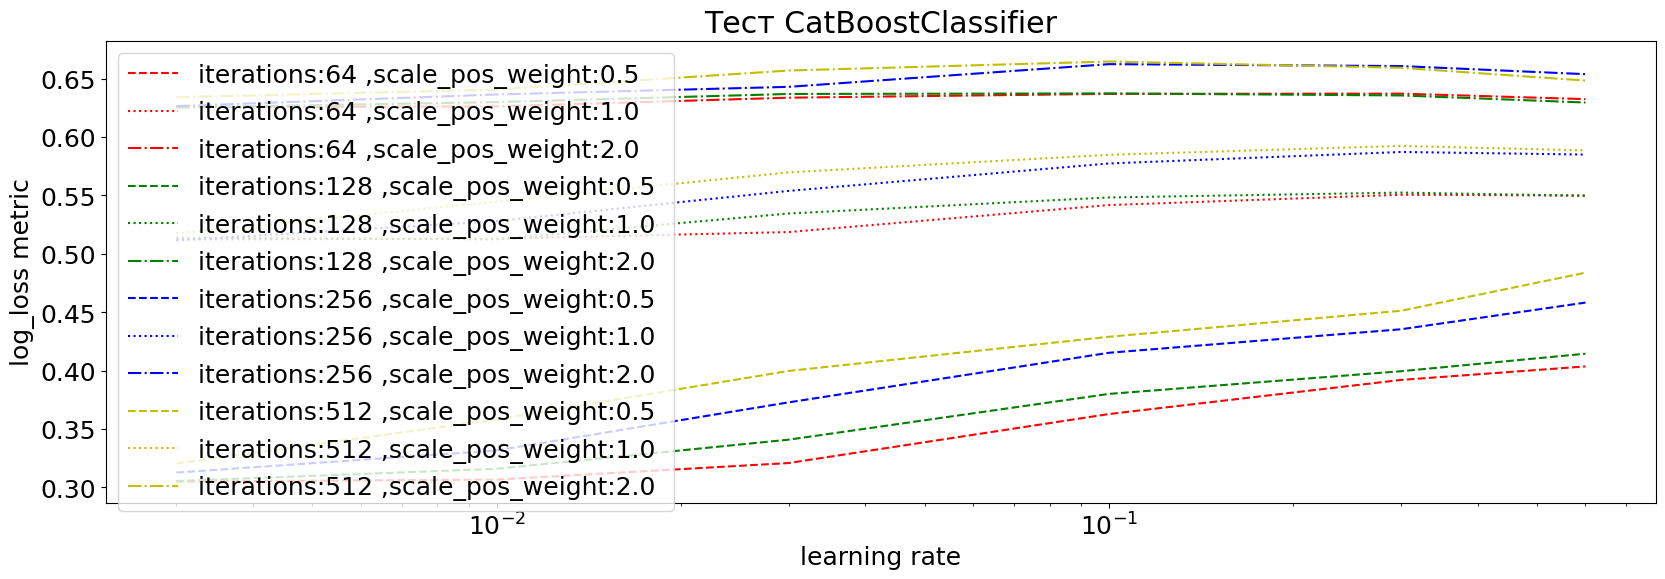

In [43]:
cbst.plot()

Модель позволяет получить метрику ~0.67 при скоростях обучения 0.1-0.3  
Увличение итераций позволяет улучшить модель, также максимумы смещены в правый край диаграммы  и там четкого спада нет  
Возможно модель немного недообучена, но увеличивать обучение можно только количеством итераций и она становится медленной.  
F1 улучшается при поправке на дисбаланс, это следует учесть в дальнейшем и попробовать настроить параметр более точно

#### MLPClassifier

Для унификации расчета и использования одного набора данных  трансформеры убраны в пайплайн.
Проверялись трехуровневая и одноуровневая модели.  
Также не предварительрных тестах проверялся оптимизатор lbfgs но он не показал никаких преимуществ и был критически медленным на трехуровневой модели.  
Я не неашел возможности поставить разные активаторы на разных уровнях и так как для классификации последним должен быть logistic(сигмоид) выбора здесь практически нет ,  

In [44]:
%%time
ohe_pipe = OneHotEncoder(min_frequency =5_000,handle_unknown='infrequent_if_exist',drop='first')
ctr_pipe = ColumnTransformer( 
        [('encoder-scaler', ohe_pipe, cat_cols)], 
        remainder=StandardScaler(),
        verbose_feature_names_out = False
    )
mlp_pipe =  Pipeline(steps = [
    ['encoder',  ctr_pipe  ],
    ['model',MLPClassifier( max_iter=1_000)]
])
mlp = TestModel(mlp_pipe)
params_grid = {
   'model__hidden_layer_sizes':[ [8], [24,8,4] ],
   'model__solver': ['adam'],
   'model__activation': ['logistic'],
   'model__early_stopping': [ True],
   'model__learning_rate_init':  [.3,.1,.03,.01,.003]  
}

mlp.cross_validate(params_grid,X_tr,y_tr )

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


CPU times: user 12min 50s, sys: 6.2 s, total: 12min 57s
Wall time: 3min 29s


{'model__activation': 'logistic',
 'model__early_stopping': True,
 'model__hidden_layer_sizes': [8],
 'model__learning_rate_init': 0.003,
 'model__solver': 'adam'}

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Молодец, что закодировал данные для нейросети и при этом использовал пайплайн, но тут есть риск dummy-ловушки.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправлено.<br>
Почему-то был уверен , что здесь drop='first' по умолчанию, наверно с чем-то спутал.   
Но OHE при этом вывел много предупреждений, чего я раньше не помню.
Поиском нашел RT на эту проблему, созданный в 20м году    
</div>


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Молодец, что поправил. Предупреждения возникают из-за неизвестных категорий в выборке. 

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


f1_score: 0.5400871108243265 	
precision_score: 0.6819663226507333 	
recall_score: 0.44707558087777083 	
accuracy_score: 0.6599475190839694 	
confusion_matrix:
 [[11577  2342]
 [ 6211  5022]]


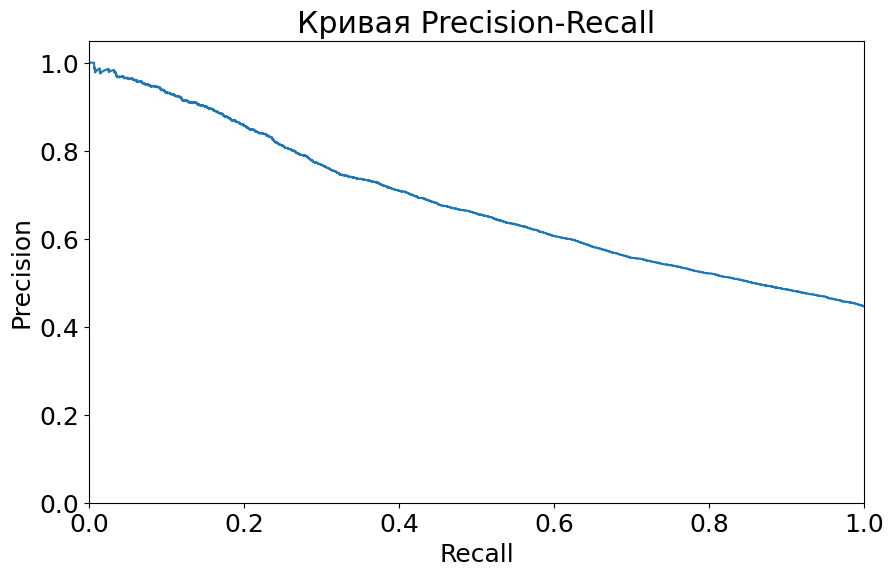

In [45]:
mlp.check_best(X_tr,y_tr,X_te,y_te)

Лучший результат по точности, но гораздо более  низкая F1 из-за большого числа ложноотрицательных результатов 

In [46]:
mlp.parse_result( index_column='learning_rate_init',forced_string_cols=['hidden_layer_sizes'] )

mean_test_f1          
hidden_layer_sizes   [24, 8, 4]       [8]
learning_rate_init                       
0.003                  0.535617  0.550501
0.010                  0.548380  0.547056
0.030                  0.532259  0.540673
0.100                  0.525615  0.535772
0.300                  0.393377  0.529536

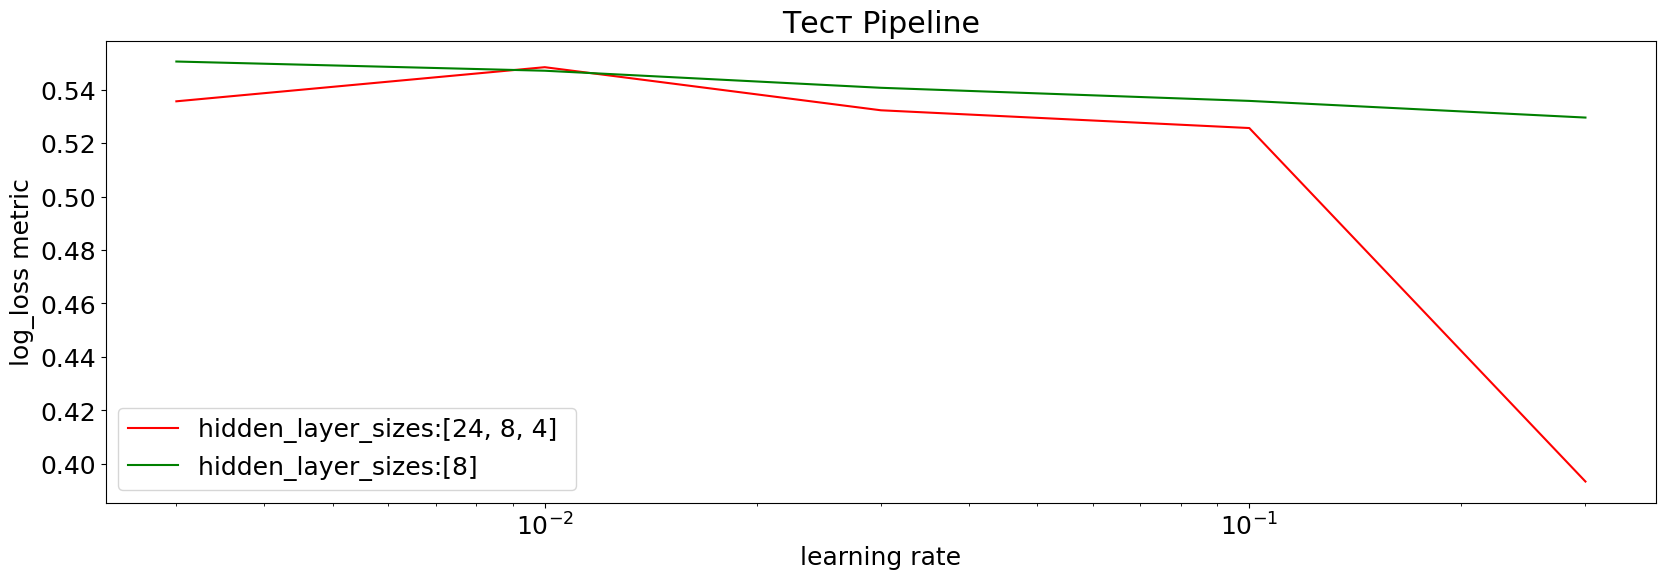

In [47]:
mlp.plot()

Увеличение количества уровней не улучшило модель 
В целом по предварительным результатам нейросеть проигрывывает CatBoost, хотя у нейросети может быть многовариантов настройки и все их не сейчас проверить 

### Torch neural network

#### Transform for neural network

In [48]:
ohe = OneHotEncoder(min_frequency =5_000,drop='first',sparse_output=False,handle_unknown='infrequent_if_exist')
ctr = ColumnTransformer( 
        [('encoder-scaler', ohe, cat_cols)],
        remainder=StandardScaler(),
#        sparse_threshold=0,
        verbose_feature_names_out = False
    )
ctr.fit(X_tr)
new_cols = ctr.get_feature_names_out()
tX_tr = pd.DataFrame( ctr.transform(X_tr) , columns = new_cols )
tX_te = pd.DataFrame( ctr.transform(X_te) , columns = new_cols ) 
input_neurons = len( tX_tr.columns )
tX_te.head()



Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


,city_infrequent_sklearn,county_orange,county_san diego,county_infrequent_sklearn,intersection_ 1,intersection_infrequent_sklearn,weather_1_cloudy,weather_1_infrequent_sklearn,location_type_highway,location_type_infrequent_sklearn,...,drug_infrequent_sklearn,phone_MISSING,phone_infrequent_sklearn,vehicle_type_sedan,vehicle_type_infrequent_sklearn,vehicle_transmission_manual,vehicle_transmission_infrequent_sklearn,distance,insurance_premium,vehicle_age
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.103144,0.206855,0.259604
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.691894,-1.397955,-0.727255
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.271582,2.675792,2.562276
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.728980,0.206855,0.259604
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.766067,0.145131,-1.056208


<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Также dummy-ловушка.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправлено.
</div>


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> 👍

### Custom Torch Neural network

Рекомендованная в курсе модель на основе Torch.
К сожалению не получилось встроить её в пайплайн , также не удалось применить к ней анализатор SHAP 
Из-за попыток применить протокол BaseEstimator код получился слишком громоздким, сорри

Cостоит из вобственно модели сети 

In [49]:
def kaiming(linear):
    nn.init.kaiming_uniform_(linear.weight)
    

def xavier(linear):
    nn.init.xavier_normal_(linear.weight)
        

class Net(nn.Sequential):

    def __init__(self):
        super(Net,self).__init__() 
        self.params = {}

    def set_params(self,params):    
        depth = len(params['levels'])
        arrange_array = lambda ar: (ar*int(depth/len(ar)))[:depth]
        self.params =  params
        self.levels = params['levels']
        self.estimator = None
        self.activs = arrange_array(params['acts'])
        self.activs[-1] = nn.Sigmoid()
#        self.fans = arrange_array(params['fans'])
        self.init_methods = arrange_array(params['init_methods'])    

        self.init_levels()

        self.learn_rate = params['learn_rate']
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learn_rate)
        self.epochs = params['epochs']

        
    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )
        else:
            return super().__getattr__(k)
        
    def init_levels(self):
        for lev in range(len(self.levels)-1):
            li = nn.Linear(self.levels[lev],self.levels[lev+1])
            self.init_methods[lev](li)
            
            self.add_module('Linear_'+str(lev),li)
            self.add_module('Activator_'+str(lev),self.activs[lev] )


    def run(self,X,y):   
        print( f'Net learns wit params: {self}\n' )
        loss=nn.CrossEntropyLoss()
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()

            preds = self.forward(X).flatten()
            loss_value = loss(preds, y)
            loss_value.backward()
            self.optimizer.step()
 
            self.estimator.check_estimate(epoch)


 И головного оценщика, который производит периодически оценку качества обучения,  
 а также должен встраиваться в популярные схемы работы, для чего выводится из BaseEstimator

In [50]:

regressive_levels = lambda depth: [ int( pow(input_neurons,(depth-i-1)/(depth-1) ) ) for i in range(depth)  ]

class NetEstimator(BaseEstimator,ClassifierMixin):
    base_params = {
        'eval_rate': .05,
        'metric': roc_auc_score,
        'epochs': 500,
        'threshold': .5,
        'depth' : 2,
        'acts':[nn.ReLU()] ,
        'init_methods':[kaiming,xavier],
        'learn_rate':.1,
        'loss':nn.BCELoss,
        'random_state': None
    }

    net_keys = ['depth','levels','epochs','acts','init_methods','learn_rate','loss']
    tuned_keys = ['depth','acts','init_methods','learn_rate','loss']
    
    def __init__(self,tX_te,y_te,**params ):
        self.params = self.base_params | params 
        self.params |= {'epochs':self.epochs, 'levels': regressive_levels(self.params['depth']) }      
        if self.random_state:
            torch.manual_seed(self.random_state)

        self.net = Net()
        self.net.set_params( self.net_params_list() )
        self.net.estimator = self

        self.eval_step =int(self.epochs*self.eval_rate)
        self.params['best'] = {'res':0,'epoch':0}
        self.params['last_res']={}
        
        self.X_te,self.y_te = self.to_tenzor(*(tX_te,y_te))


    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )    

    def set_params(self, **params):
        self.params |= params
        
#     def get_params(self, deep=True):
#         return( { k:v for k,v in self.params.items() if k in self.tuned_keys } )

#     def _validate_params(self):
#         return True
    
    def net_params_list(self):
        return( { k:v for k,v in self.params.items() if k in self.net_keys } )
        
    def check_best(self):
        if self.best['res'] < self.last_res['res']:
            self.params['best'] = self.last_res.copy()

    def estimate(self,epoch):
        self.params['epoch']=epoch
        self.net.eval()
        with torch.no_grad():
            test_preds = self.net.forward(self.X_te).detach().numpy().flatten()
            res = self.metric(self.y_te.numpy(),test_preds )
            print(self.epoch,res)
            self.params['last_res']={'res':res,'epoch':self.epoch,'preds':test_preds }
            self.check_best()
 
    def to_tenzor(self,*args):
        return( torch.FloatTensor(x.values) for x in args) 
    
    def final_estimate(self):
        self.estimate(self.epochs)
        print(f"best {self.best['res']:.4f} \t (best epoch: {self.best['epoch']} ) ")                

        
        
    def check_estimate(self,epoch):
        if (epoch % self.eval_step == 0):
            self.estimate(epoch)
    
    def run(self,X,y):
        self.net.run()
        self.final_estimate()

    def fit(self,X,y):
        try:
            self.params['eval_rate'] = 0.2 
            self.net.run(*self.to_tenzor(X,y))
        except Exception  as e:
#            print(e)
            raise(e)
    
        return( self )
        
    def score(self): 
        return self.best['res']
    def scoring(self): 
        return self.best['res']
    
    def predict_proba(self,x):
        return( self.net.forward(*self.to_tenzor(x)).detach().numpy().flatten() )
        
    def predict(self,y):
        preds = self.predict_proba(y)
        return( [ int( j > self.threshold ) for j in preds ]  )

Процедура перебора параметров  

In [51]:
def dict_of_lists_to_grid(di,li=[dict()]):
    it = di.popitem()    
    li =   [  d | {it[0]:e }  for e in it[1]  for d in li ]     
    if di:
        li = dict_of_lists_to_grid(di,li)
    return li
#dict_of_lists_to_grid({'a':[3,4],'b':[50,60,70],'c':[ [100,500],200]})

In [52]:
permanent_params = {'eval_rate':.2,'metric':roc_auc_score,'epochs':2000, 
                    'init_methods':[kaiming,xavier],'acts':[nn.Sigmoid()]   } 



И сам класс подбора

In [53]:
class NetEstimatorTest(TestModel):
    def __init__(self, model,fit_params={} ):
        super().__init__(model,fit_params)
        self.primary_score = 'mean_test_score'
    
    def run(self,param_grid):    
        run_grid = dict_of_lists_to_grid(param_grid) 
        dr = pd.DataFrame([],columns=list(run_grid[0].keys())+[self.primary_score] )
        for p in run_grid:    
            print(p)
            self.model.fit(tX_tr, y_tr)
            pr = self.model.predict(tX_te )
            d = p | { self.primary_score : f1_score(y_te,pr)}
            dr = pd.concat([dr,pd.DataFrame([d])],axis=0)
            print('Error matrix\n',confusion_matrix(y_te,pr) )
     
        self.sel = pd.pivot_table(dr,index='learn_rate',columns=['threshold','depth'],values=self.primary_score)    

Для промежуточной оценки использовалась метрика auс_roc, однако в результат записывалась accuracy, чтобы можно было сравнить со стандартными моделями  
Так как обучение часто срывалось (результат был либо все 0 либо все 1), в подборе гиперпараметров сети  использовалась метрика accuracy а при переборе параметров перебирался также порог. 

In [54]:
nt = NetEstimatorTest( NetEstimator(tX_te,y_te,**permanent_params  ) )
nt.run({'learn_rate':[.003,.01,.03,.1,.3],'depth':[2,4,6],'threshold':[.25,.5,.7,.8] })

{'threshold': 0.25, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.5066585854633112
400 0.6580140096207325
800 0.6574256869559567
1200 0.6572351107190246
1600 0.6571848427747964
Error matrix
 [[12111  1808]
 [ 6913  4320]]
{'threshold': 0.5, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.657156972990844
400 0.6571487639563739
800 0.657150948128771
1200 0.6571451886932117
1600 0.6572585258146185
Error matrix
 [[12368  1551]
 [ 7202  4031]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6572179571308294
400 0.6571441205913368
800 0.6571451183391959
1200 0.657145348588702
1600 0.6571294805602484
Error matrix
 [[12174  1745]
 [ 6981  4252]]


400 0.6571453389949725
800 0.6571534680816973
1200 0.6571115978486176
1600 0.6571449808290744
Error matrix
 [[12159  1760]
 [ 6959  4274]]
{'threshold': 0.5, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6571414215554612
400 0.6571451119433764
800 0.6570955955079523
1200 0.6571455404632903
1600 0.6571450831621881
Error matrix
 [[12196  1723]
 [ 7006  4227]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6571561255447456
400 0.6571450863600979
800 0.6571434938010149
1200 0.6570449054396299
1600 0.6571453549845216
Error matrix
 [[12175  1744]
 [ 6981  4252]]
{'threshold': 0.8, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6571455596507492
4

400 0.6571448784959606
800 0.6571695855471156
1200 0.6571450639747292
1600 0.6571404909637077
Error matrix
 [[12175  1744]
 [ 6981  4252]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6571453070158745
400 0.6571450831621881
800 0.6571454669113648
1200 0.6571451055475568
1600 0.6571450543809999
Error matrix
 [[12176  1743]
 [ 6985  4248]]
{'threshold': 0.8, 'depth': 2, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6571451918911215
400 0.6571451375266548
800 0.6572036432865414
1200 0.6571450415893607
1600 0.6571451087454665
Error matrix
 [[12193  1726]
 [ 6999  4234]]
{'threshold': 0.25, 'depth': 4, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6571515077629868
400

In [55]:
nt.sel

threshold       0.25                          0.50                      \
depth              2         4         6         2         4         6   
learn_rate                                                               
0.003       0.497667  0.496216  0.493558  0.479453  0.493265  0.493558   
0.010       0.495926  0.493558  0.491939  0.493558  0.493558  0.493558   
0.030       0.495048  0.495865  0.493558  0.491998  0.493558  0.493586   
0.100       0.493558  0.485888  0.493558  0.493558  0.493558  0.493178   
0.300       0.493586  0.493586  0.493558  0.493586  0.493558  0.493558   

threshold       0.70                          0.80                      
depth              2         4         6         2         4         6  
learn_rate                                                              
0.003       0.493558  0.493645  0.493558  0.493558  0.493882  0.493558  
0.010       0.498275  0.493586  0.493558  0.493735  0.487501  0.495955  
0.030       0.493586  0.493558  0.493586  0.493558  0.493558  0.492882  
0.100       0.493558  0.493823  0.493733  0.493558  0.502904  0.493558  
0.300       0.493265  0.491130  0.493558  0.492526  0.498043  0.494028

Гораздо более низкий результат по сравнению со всеми остальными, с сильным перекосом в сторону FN 

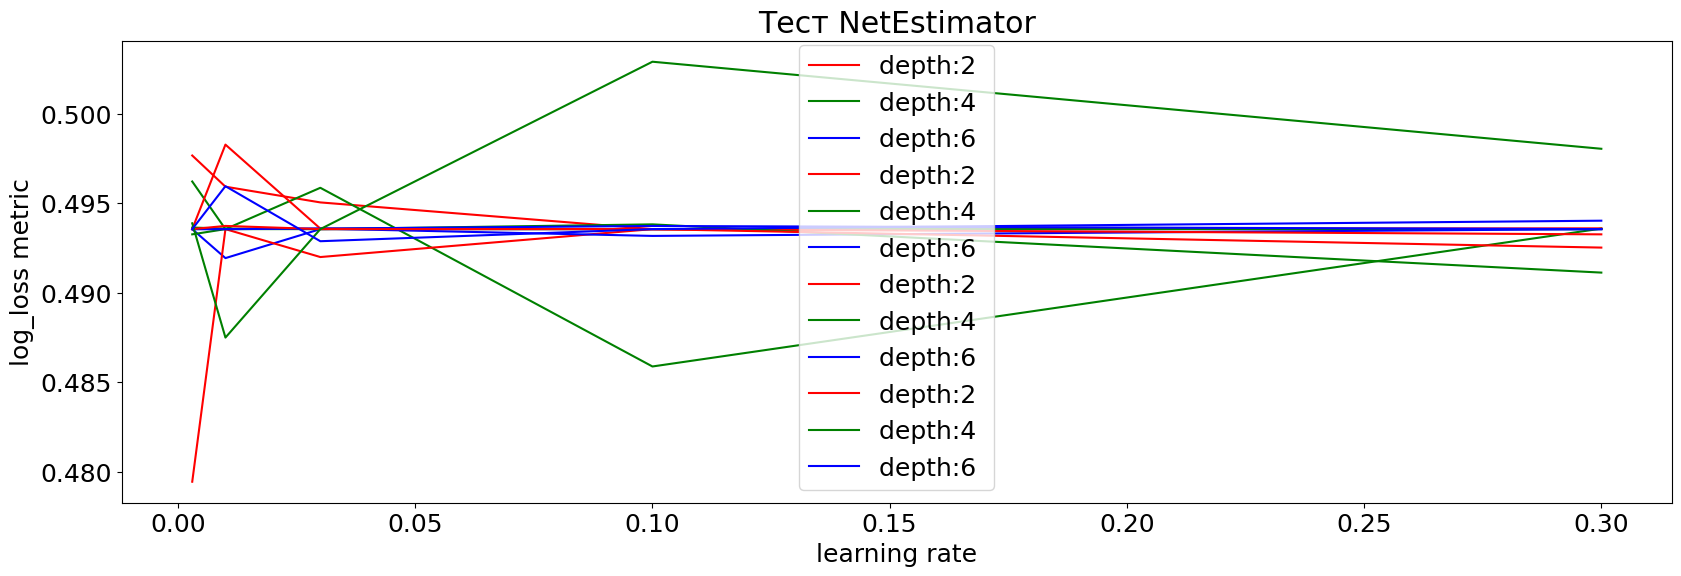

In [56]:
ResultPlotter(nt).plot()

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> В целом очен сильный раздел ML, молодец!

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Необходимо провести графический анализ «Матрица ошибок». Вывести полноту и точность на график.

<div class="alert alert-info">
<b>Комментарий студента:</b>
Как я понял это относится только к лучшей модели и имеется в виду PR-кривая <br>
Добавлено в проверку модели в классе
</div>    

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Да, вопросов нет.

Конкретные выводы по кривой  зависят от уточнения задачи, какие ошибки хуже 

## Проведите анализ важности факторов ДТП

Родной feature importance from lgb  

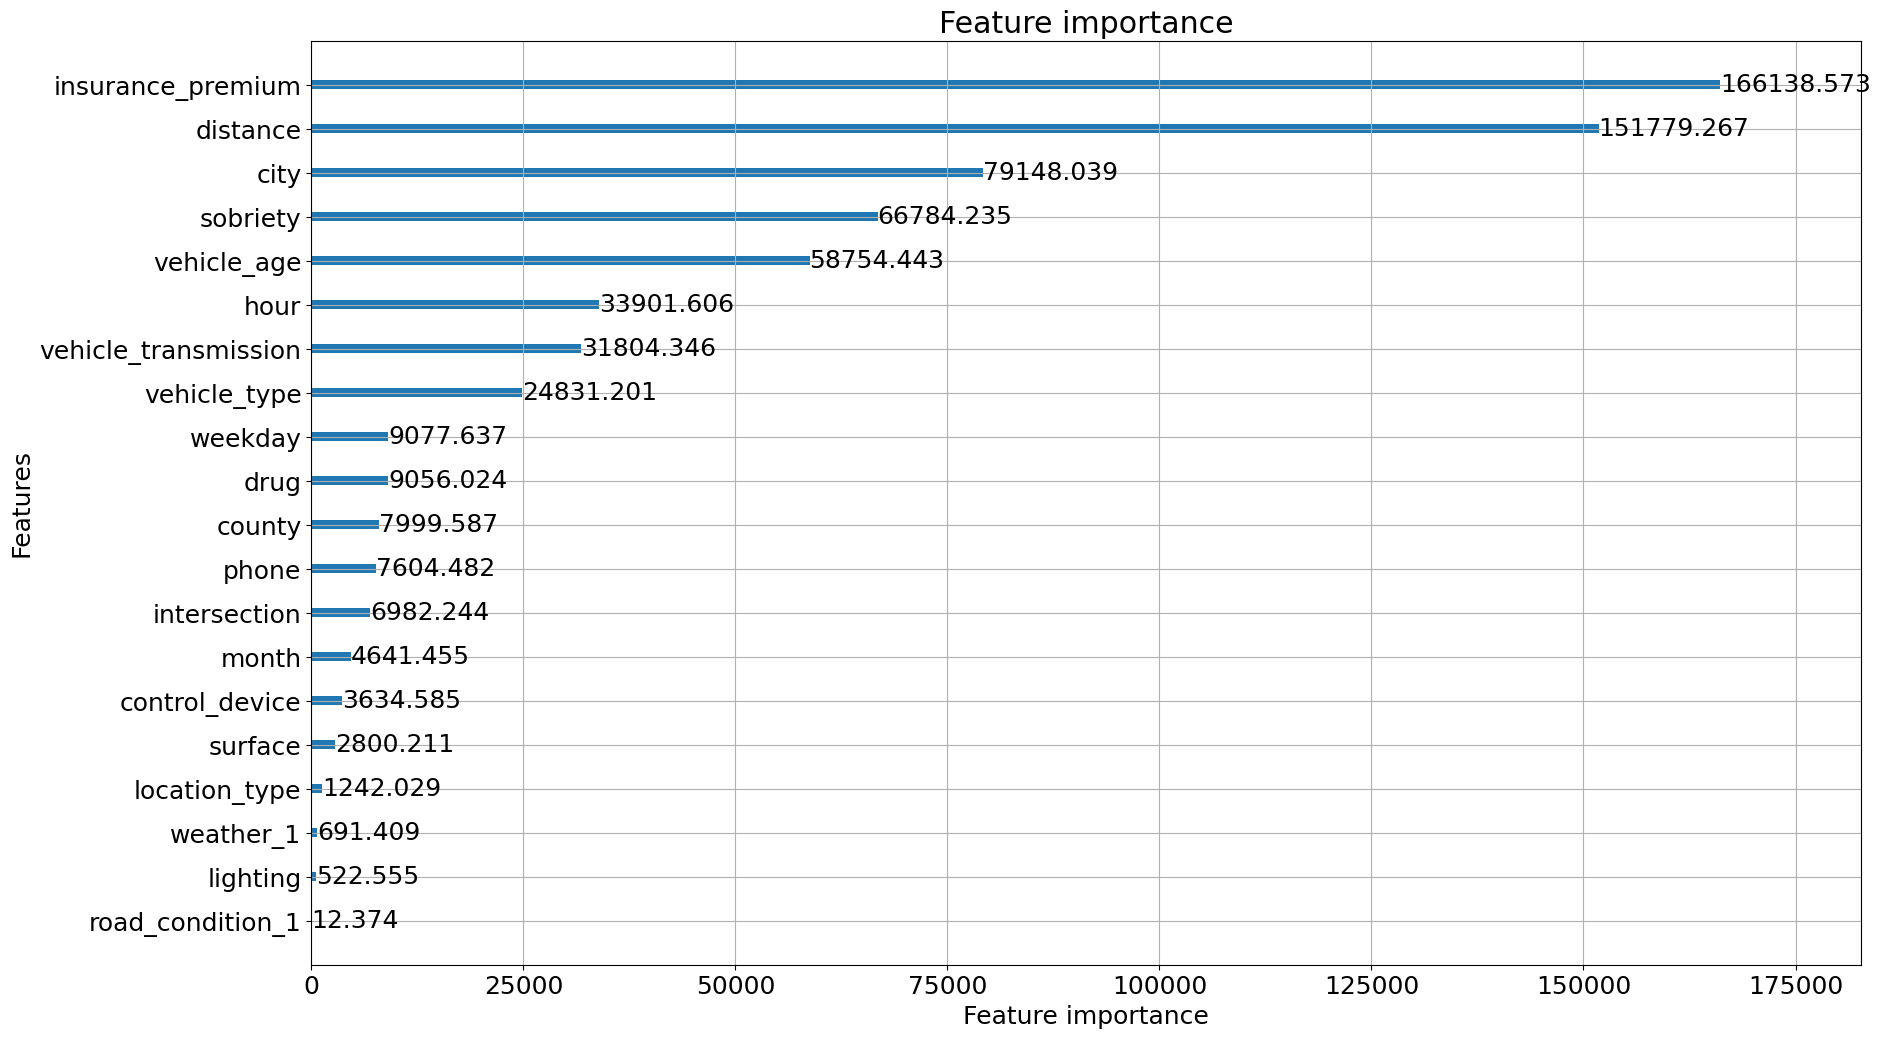

In [57]:
lgb.plot_importance(lgbm.model,importance_type='gain',max_num_features=20,figsize=(20,12) );

и оценка свой модели Catboost'ом

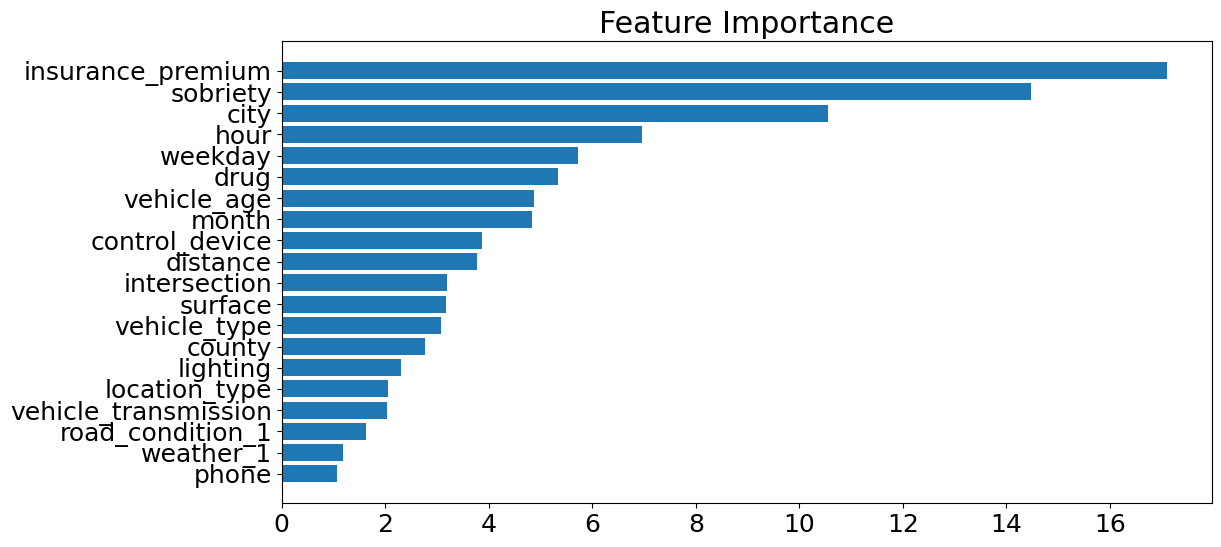

In [58]:
def native_catboost_explanation(cbst,X):
    feature_importance = cbst.model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_te.columns)[sorted_idx])
    plt.title('Feature Importance')
native_catboost_explanation(cbst,X_te)    

при общей схожести оценок, есть отличие в третей позиции и ниже.  
Оценки моделей с помощью SHAP   

In [59]:
expl_lgbm = shap.Explainer(lgbm.model)
values_lgbm = expl_lgbm.shap_values(X_te)[1]
expl_cbst = shap.Explainer(cbst.model)
values_cbst = expl_cbst.shap_values(X_te)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


общая 

--------------------------LGBM ------------------->


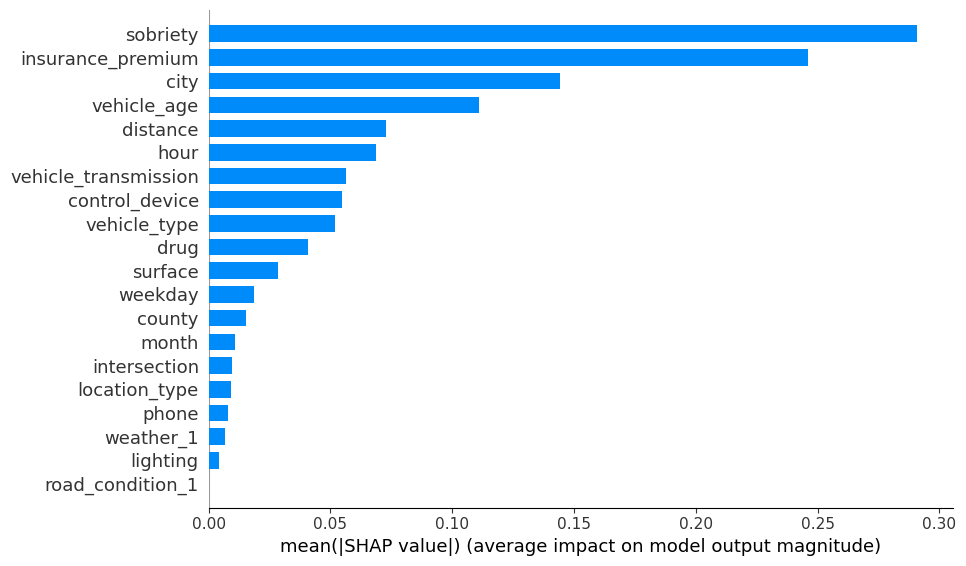

--------------------------CATBOOST------------------->


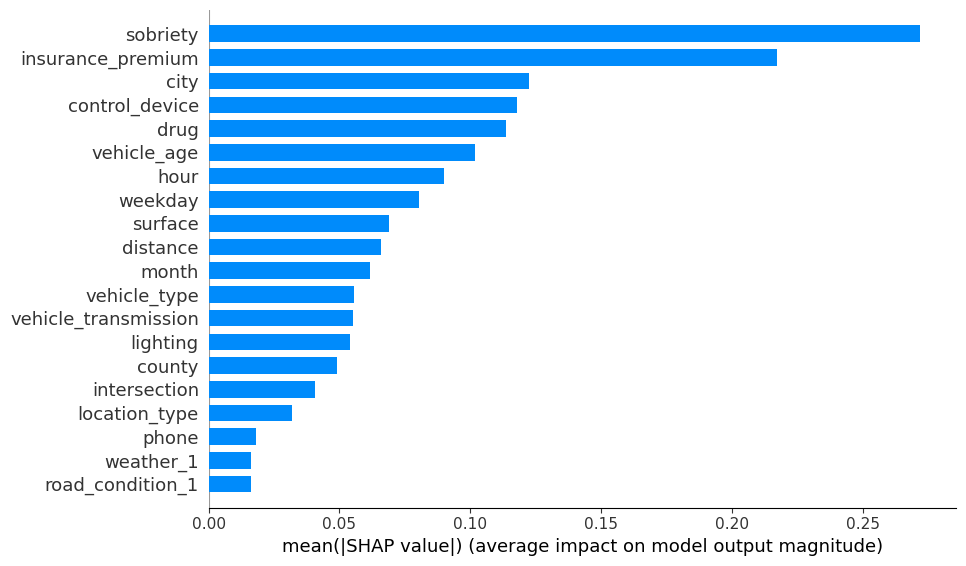

In [60]:
print('--------------------------LGBM ------------------->')
shap.summary_plot(values_lgbm, X_te,plot_type='bar',plot_size=(10,6),title='LGBM')
print('--------------------------CATBOOST------------------->')
shap.summary_plot(values_cbst, X_te,plot_type='bar',plot_size=(10,6),title='Catboost')

 и подробная

--------------------------LGBM ------------------->


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


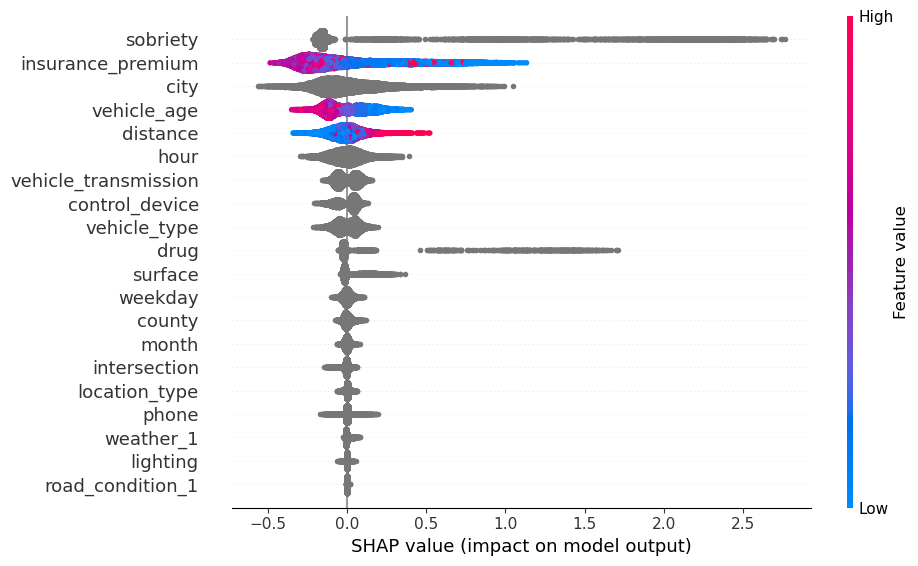

--------------------------CatBoost ------------------->


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


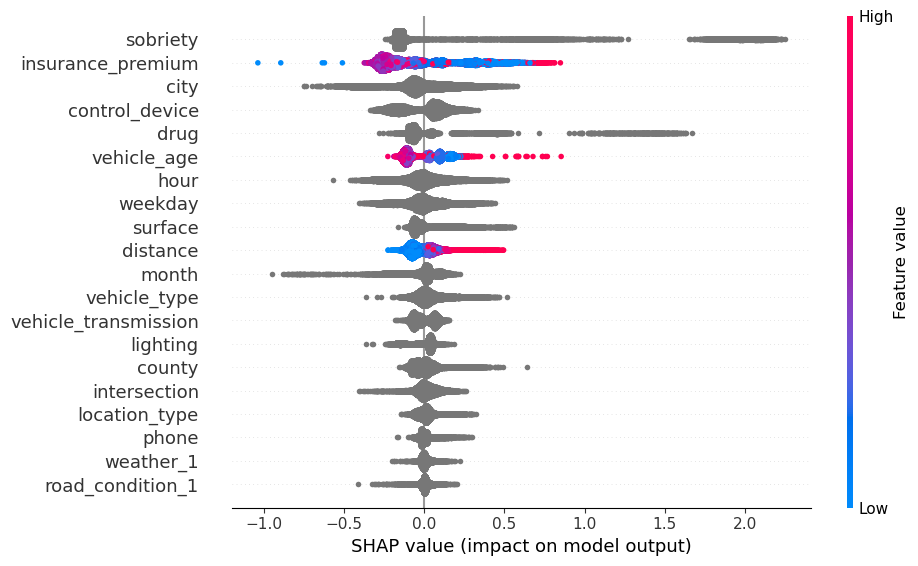

In [61]:
print('--------------------------LGBM ------------------->')
shap.summary_plot(values_lgbm, X_te,plot_type='dot',plot_size=(10,6))
print('--------------------------CatBoost ------------------->')
shap.summary_plot(values_cbst, X_te,plot_type='dot',plot_size=(10,6))

Здесь порядок важности признаков расходится еще сильнее, но в целом можно сделать определенные выводы 
Решающий вклад дают числовые признаки и признаки раздельные для участников (таблица parties)   
<b>Важнейшие признаки- стоимость страховки и состояние опьянения</b>  
Также важным признаком является  возраст машины, причем как показал и предварительный анализ, виновность ниже в середине и выше при крайних значениях.
Из прочих  признаков можно отметить довольно большое влияние города, но это может быть связано со стоимостью страховки или даже с трезвостью. Также влияет время суток(тоже возможно связано с трезвостью).
Погода, состояние дороги, освещение и использование телефона на виновность влияют меньше всего

Примитивный анализ важнейщих признаков выполнен в ч.2.

Хотя SHAP можно применить к оценке MLP классифкатора, там нужен специфический код который работает долго , и в окончательный вариант я его не включил (выводы примерно те же, но с нюансами)

#### Пересмотр задач для рабочей группы 

Исходя из собственного понимания ситуации, я бы сосредоточился на следующих задачах , имея в виду прежде всего основные причины виновности :

##### Определить влияние факторов виновности на общий материальный эффект

Посчитать долю суммы страховок в инцидентах с каждой категорией виновников к общей сумме страховок.  
Хотя такой задачи нет, она неизбежно возникнет, если работа будет продолжаться :)  

* Создать  подзапрос collision_costs к базе данных, вычисляющий для каждого инцидента сумму страховок участников: для этого сгруппировать данные по case_id и вычислить сумму страховок участников для каждого инцидента
* С помощью этого подзавроса посчитать суммарную стоимость страховок для каждой категории виновников по sobriety, для этого связать вторую копию parties c cosllision_costs по саse_id, сгруппировать по sobriety  и отфильтровать по признаку виновности at_fault=1, суммировать стомиость страховок и количество инцидентов по группамб также вычислить средние стоимость инцидентов с помощью функции avg 
* Загрузить запрос в датафрейм, пересчитать количество и суммарную стоимость страховок в проценты  
* Иллюстрировать результаты круговыми диаграммами, сравнить их между собой
* Построить столбчатую диаграмму для средней стоимости инцидента в зависимости от трезвости 

##### Проверить связь объективных факторов с виновностью участников 

На большом расстоянии от трасс и в некоторых городах виновников видимо значительно больше, хотя должно быть поровну :)
Связано ли это с другими факторами (трезвость/страховка) или это независимая тенденция?
Есть ли что-то общее у этих районов? 

Посчитать коэффициент корреляции между долей виновников и долей пьяных по городам:
- Построить запрос:
    - связать таблицы collisions и partis по case_id
    - применить группировку по городу и для каждого города:
    - найти количество записей в базе(count)
    - найти количество виновников,просумировав fault_at
    - найти количество пьяных просуммировав 1 для инцидентов с пьяными водителями
- загрузить запрос в датафрейм
- в датафрейме посчитать доли виновных и пьяных водителей по городам
- найти коэффициент корреляции между этими векторами
- для 10 крупнейших по количеству инцидентов городов вывести доли виновных и пьяных на столбчатую диаграмму


##### Исследовать сложную зависимость виновности от возраста автомобиля

Это третий признак по важности
Есть непонятный миниумум виновности в середине графика , возомжно это результат взаимодействия разнонаправленных тенденций?
Пока не могу сказать , как это проверить .

##### Определить вес категорий страховки в базе инцидентов

Это важный признак и влияние его на виновность велико.  
Возможно, выделяется какая-то одна группа, на которой можно сосредоточиться (хотя по SHAP-dot не похоже)

##### Определить удельный вес пьяных инцидентов в общей базе ис сравнить с предыдущим показателем

Частично это сделано во второй части, нужно сравнение с предыдущим показателем по количиству инцидентов с учетом тяжести и по  сумме страховок.  
Если один из этих двух показателей намного больше, нужно сосредоточиться в первую очередь на нём

##### Проверить согласованность базы за предыдущие годы 

Запустить обученные и необученные модели на данных за предыдущие годы.  
Сранить результаты .  
Возможно, есть резкие изменения на которые надо обратить внимание?
Если модели  обучаются заметно лучше на прошлогодних данных, может взять их за основу?  

<div class="alert alert-block alert-info" >
   <font color="green">.
        <b>Комментарий студента v2:</b> <br>
        Добавлены решения для задач 1,2
    </font>
</div>

<b>Примечание</b>
Возможно я неправильно понял это задание и задачи слишком общие, а требуется декомпозиция на элементарные операции - фактически "написать  запрос к базе  словами".

Просьба тогда это указать .

С другой стороны, эти постановка таких задач мне все же кажестя более разумной чем "оборудовать машины трубками трезвости и камерами" - в этом я точно не разбираюсь :)

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Нет выбора оптимальной модели.

<div class="alert alert-info">
<b>Комментарий студента:</b> Добавил в выводы
</div>    

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Согласен с твоим выбором

## Выводы

* Важнейшими факторами , влияющими  на  виновность являются стоимость страховки и степень опъянения, затем - возраст машины  
* Меньше вляиют место и время, нужно проверить возможную зависимость от основных признаков
* Погода и состояние дороги влияют мало
* Предварительно, наиболее устойчивой моделью для предсказания виновности является <br><b>Catboost  с числом итераций >256 и скоростью обучения 0.1-0.3</b>; <br>эта модель позволяет получить метрику F1 c точностью предсказания ~0.65  
* Нужно уточнить постановку задачи - должны ли мы сосредоточиться на предсказании  виновника или на предсказании ущерба? 
* Нужно проверить корректность данных по дистанции от основной трассы
* Нужно пополнить данные за 2012 год или перейти на данные предыдущего года
* Для предсказания не только виновности но и аварийности важно иметь данные по безаварийной езде, например трафик по трассам , перекресткам и городам

<b>Disclaimer.</b>  
Я видимо слишком увлекся программированием в попытках построить универсальные классы для тестов.   
Между тем время уже поджимает а в задании курса много мелких задач в понимании которых я не уверен.  
Так что я рещил сдать его в таком виде, а то может придется что-то переделывать.  
Просьба указать в первую очередь критчные  пропуски и ошибки

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**

Спасибо за твой проект! У тебя хорошая работа! В тебе виден будущий профессионал своего дела!

**Положительные моменты проекта**:
* Прекрасное владение инструментами обработки данных!
* Умелое проведение машинного обучения!
* Все этапы работы проделаны очень осмысленно! Каждый шаг снабжен пояснениями и выводами!
* Работа имеет четкую структуру и выполнена аккуратно, проверять - одно удовольствие!
* Владение классами на высоте!

**Обязательные исправления отмечены красными комментариями, без них, к сожалению, не получится принять работу:**
* Оформление графиков
* Решение  2-х задач
* Обоснование выбора метрики для моделей
* dummy ловушка
* Вывод матрицы ошибок
* Выбор оптимальной модели

**Желаю удачи и жду твой проект на повторное ревью!**😉